# تدريب شبكات الخصومة التوليدية

## إستيراد المكتبات

In [1]:
import os
import numpy as np
from os import walk, getcwd
import json
import pickle as pkl
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

## البيانات

In [3]:
def load_safari(folder):

    mypath = os.path.join("./data", folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0: 
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1
        
    return xtotal, ytotal

In [4]:
(x_train, y_train) = load_safari(DATA_NAME)

In [5]:
x_train.shape

(80000, 28, 28, 1)

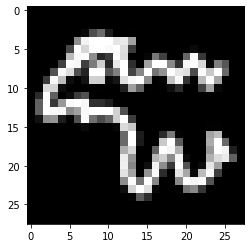

In [6]:
plt.imshow(x_train[200,:,:,0], cmap = 'gray')

## بناء شبكة الخصومة التوليدية

In [7]:
class GAN():
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser
        self.z_dim = z_dim

        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

        self._build_discriminator()
        self._build_generator()

        self._build_adversarial()

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_discriminator(self):

        ### المميز
        # حدد المدخلات للمميز (الصورة).
        discriminator_input = Input(shape=self.input_dim, name='discriminator_input')

        x = discriminator_input
        
        # كدس طبقات تلافيفية فوق بعضها البعض
        for i in range(self.n_layers_discriminator):

            x = Conv2D(
                filters = self.discriminator_conv_filters[i]
                , kernel_size = self.discriminator_conv_kernel_size[i]
                , strides = self.discriminator_conv_strides[i]
                , padding = 'same'
                , name = 'discriminator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

            x = self.get_activation(self.discriminator_activation)(x)

            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)
        
        #قم بتسطيح آخر طبقة لف لرياضي ( طبقة تلافيفية ) إلى متجه.
        x = Flatten()(x)
        
        #طبقة كثيفة من وحدة واحدة ،
        #مع دالة التنشيط سيغمويد التي تحول الناتج من الطبقة الكثيفة إلى النطاق [0 ، 1].
        discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = self.weight_init)(x)
        
        #نموذج Keras الذي يحدد شبكة المميز وهو  نموذج يأخذ صورة إدخال ويخرج رقمًا واحدًا بين 0 و 
        self.discriminator = Model(discriminator_input, discriminator_output)


    def _build_generator(self):

        ### المولد
        
        #تحديد المدخلات للمولد - متجه طوله 100.
        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input
        
        #طبقة كثيفة تتكون من 3136 وحدة
        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)
        
        # تطبيق تسوية الحزم
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        # تطبيق دالة التنشيط
        x = self.get_activation(self.generator_activation)(x)
        
        # إعادة تشكيل التنسور إلى  7 × 7 × 64
        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        #######
        #Conv2D قوم بتمرير هذا من خلال أربع طبقات   
        # Upsampling2D أول طبقتين مسبوقتين بطبقات
        # لإعادة تشكيل التنسور إلى 14 × 14 ، ثم 28 × 28 (حجم الصورة الأصلي)
        # في الكل ما عدا الطبقة الأخيرة ، نستخدم تسوية الحزم
        # Relu  وتنشيط 
        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)
            
            # tanh بعد الطبقة اللف الرياضي الأخيرة ، نستخدم تنشيط
            # لتحويل الإخراج إلى النطاق [–1 ، 1] ، لمطابقة مجال الصورة الأصلي.

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                    
                
            else:

                x = Activation('tanh')(x)

        # النموذج لذي يحدد المولد - نموذج يقبل متجهًا بطول 100 ويخرج موترًا للشكل [28 ، 28 ، 1].

        generator_output = x

        self.generator = Model(generator_input, generator_output)

       
    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### تحميع المميز 
        
        #يتم تجميع المميّز مع خسارة الانتروبيا المتقاطعة الثنائية 
        #، حيث أن الاستجابة ثنائية ولدينا مخرج واحد  مع دالة تنشيط سيغمويد 
        self.discriminator.compile(
        optimizer=self.get_opti(self.discriminator_learning_rate)  
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )
        
        ### تجميع شبكة الخصومة التوليدية

        #  نقوم بتجميد أوزان المميز - وهذا لا يؤثر على نموذج المميز الحالي الذي قمنا بتجميعه مسبقاً.
        self.set_trainable(self.discriminator, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        
        #نحدد نموذجًا جديدًا يكون مدخله عبارة عن متجه كامنه لديها 100 بعد ؛
        #يتم تمريرها من خلال المولد والمميز الذي تم تجميده لإنتاج المخرج كإحتمال. 

        self.model = Model(model_input, model_output)
        
        # مرة أخرى ، نستخدم خسارة الانتروبيا المتقاطعة الثنائية ا للنموذج المشترك 
        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate) , loss='binary_crossentropy', metrics=['accuracy']
        , experimental_run_tf_function=False
        )

        self.set_trainable(self.discriminator, True)



    # تدريب المميز
    def train_discriminator(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real, d_acc_real =   self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =   self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder
    , print_every_n_batches = 50
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)

            self.epoch += 1

    
    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.discriminator, to_file=os.path.join(run_folder ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                , self.discriminator_conv_filters
                , self.discriminator_conv_kernel_size
                , self.discriminator_conv_strides
                , self.discriminator_batch_norm_momentum
                , self.discriminator_activation
                , self.discriminator_dropout_rate
                , self.discriminator_learning_rate
                , self.generator_initial_dense_layer_size
                , self.generator_upsample
                , self.generator_conv_filters
                , self.generator_conv_kernel_size
                , self.generator_conv_strides
                , self.generator_batch_norm_momentum
                , self.generator_activation
                , self.generator_dropout_rate
                , self.generator_learning_rate
                , self.optimiser
                , self.z_dim
                ], f)

        self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.discriminator.save(os.path.join(run_folder, 'discriminator.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [8]:
gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [9]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

In [10]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       2049

## التدريب

In [11]:
BATCH_SIZE = 64
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5

In [12]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 [D loss: (0.738)(R 0.684, F 0.791)] [D acc: (0.422)(0.844, 0.000)] [G loss: 0.680] [G acc: 1.000]
1 [D loss: (1.014)(R 0.625, F 1.403)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.669] [G acc: 1.000]
2 [D loss: (0.684)(R 0.659, F 0.709)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.651] [G acc: 1.000]
3 [D loss: (0.671)(R 0.648, F 0.695)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.605] [G acc: 1.000]
4 [D loss: (0.669)(R 0.607, F 0.730)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.537] [G acc: 1.000]
5 [D loss: (0.744)(R 0.546, F 0.941)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.603] [G acc: 1.000]
6 [D loss: (0.674)(R 0.596, F 0.751)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.580] [G acc: 1.000]
7 [D loss: (0.712)(R 0.563, F 0.862)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.626] [G acc: 1.000]
8 [D loss: (0.688)(R 0.589, F 0.788)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.646] [G acc: 1.000]
9 [D loss: (0.681)(R 0.565, F 0.796)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.666] [G acc: 1.000]


80 [D loss: (0.622)(R 0.516, F 0.728)] [D acc: (0.680)(0.938, 0.422)] [G loss: 0.902] [G acc: 0.000]
81 [D loss: (0.617)(R 0.476, F 0.759)] [D acc: (0.547)(0.922, 0.172)] [G loss: 1.002] [G acc: 0.000]
82 [D loss: (0.572)(R 0.471, F 0.673)] [D acc: (0.742)(0.859, 0.625)] [G loss: 1.329] [G acc: 0.000]
83 [D loss: (0.656)(R 0.458, F 0.854)] [D acc: (0.539)(0.859, 0.219)] [G loss: 1.111] [G acc: 0.000]
84 [D loss: (0.593)(R 0.482, F 0.704)] [D acc: (0.680)(0.844, 0.516)] [G loss: 1.125] [G acc: 0.000]
85 [D loss: (0.522)(R 0.439, F 0.604)] [D acc: (0.852)(0.922, 0.781)] [G loss: 1.353] [G acc: 0.000]
86 [D loss: (0.534)(R 0.328, F 0.740)] [D acc: (0.695)(0.906, 0.484)] [G loss: 2.007] [G acc: 0.000]
87 [D loss: (0.606)(R 0.518, F 0.694)] [D acc: (0.672)(0.781, 0.562)] [G loss: 1.119] [G acc: 0.062]
88 [D loss: (0.496)(R 0.222, F 0.771)] [D acc: (0.695)(0.969, 0.422)] [G loss: 1.283] [G acc: 0.000]
89 [D loss: (0.563)(R 0.181, F 0.945)] [D acc: (0.641)(1.000, 0.281)] [G loss: 1.713] [G ac

161 [D loss: (0.718)(R 0.648, F 0.788)] [D acc: (0.484)(0.594, 0.375)] [G loss: 0.731] [G acc: 0.109]
162 [D loss: (0.674)(R 0.666, F 0.682)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.730] [G acc: 0.141]
163 [D loss: (0.684)(R 0.634, F 0.733)] [D acc: (0.453)(0.594, 0.312)] [G loss: 0.751] [G acc: 0.078]
164 [D loss: (0.678)(R 0.676, F 0.680)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.753] [G acc: 0.094]
165 [D loss: (0.776)(R 0.612, F 0.941)] [D acc: (0.414)(0.688, 0.141)] [G loss: 0.755] [G acc: 0.016]
166 [D loss: (0.693)(R 0.721, F 0.666)] [D acc: (0.547)(0.219, 0.875)] [G loss: 0.743] [G acc: 0.047]
167 [D loss: (0.679)(R 0.695, F 0.664)] [D acc: (0.648)(0.438, 0.859)] [G loss: 0.757] [G acc: 0.031]
168 [D loss: (0.671)(R 0.660, F 0.682)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.754] [G acc: 0.078]
169 [D loss: (0.695)(R 0.678, F 0.711)] [D acc: (0.523)(0.500, 0.547)] [G loss: 0.757] [G acc: 0.031]
170 [D loss: (0.683)(R 0.668, F 0.699)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.

243 [D loss: (0.703)(R 0.667, F 0.739)] [D acc: (0.477)(0.562, 0.391)] [G loss: 0.759] [G acc: 0.109]
244 [D loss: (0.692)(R 0.681, F 0.702)] [D acc: (0.523)(0.516, 0.531)] [G loss: 0.731] [G acc: 0.328]
245 [D loss: (0.682)(R 0.658, F 0.707)] [D acc: (0.531)(0.672, 0.391)] [G loss: 0.754] [G acc: 0.203]
246 [D loss: (0.682)(R 0.667, F 0.696)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.757] [G acc: 0.125]
247 [D loss: (0.689)(R 0.669, F 0.709)] [D acc: (0.570)(0.688, 0.453)] [G loss: 0.752] [G acc: 0.266]
248 [D loss: (0.693)(R 0.678, F 0.707)] [D acc: (0.555)(0.578, 0.531)] [G loss: 0.775] [G acc: 0.141]
249 [D loss: (0.686)(R 0.677, F 0.695)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.756] [G acc: 0.109]
250 [D loss: (0.680)(R 0.661, F 0.699)] [D acc: (0.633)(0.656, 0.609)] [G loss: 0.746] [G acc: 0.219]
251 [D loss: (0.681)(R 0.672, F 0.689)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.803] [G acc: 0.062]
252 [D loss: (0.679)(R 0.673, F 0.686)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.

325 [D loss: (0.691)(R 0.684, F 0.699)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.769] [G acc: 0.281]
326 [D loss: (0.703)(R 0.622, F 0.783)] [D acc: (0.500)(0.625, 0.375)] [G loss: 0.897] [G acc: 0.062]
327 [D loss: (0.684)(R 0.676, F 0.692)] [D acc: (0.570)(0.578, 0.562)] [G loss: 0.795] [G acc: 0.109]
328 [D loss: (0.648)(R 0.606, F 0.689)] [D acc: (0.648)(0.672, 0.625)] [G loss: 0.775] [G acc: 0.266]
329 [D loss: (0.660)(R 0.583, F 0.738)] [D acc: (0.617)(0.703, 0.531)] [G loss: 0.809] [G acc: 0.141]
330 [D loss: (0.659)(R 0.631, F 0.688)] [D acc: (0.648)(0.688, 0.609)] [G loss: 0.822] [G acc: 0.188]
331 [D loss: (0.694)(R 0.631, F 0.757)] [D acc: (0.555)(0.656, 0.453)] [G loss: 0.871] [G acc: 0.062]
332 [D loss: (0.663)(R 0.653, F 0.673)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.831] [G acc: 0.156]
333 [D loss: (0.653)(R 0.629, F 0.678)] [D acc: (0.609)(0.625, 0.594)] [G loss: 0.823] [G acc: 0.266]
334 [D loss: (0.646)(R 0.582, F 0.711)] [D acc: (0.641)(0.750, 0.531)] [G loss: 0.

406 [D loss: (0.645)(R 0.626, F 0.664)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.970] [G acc: 0.062]
407 [D loss: (0.631)(R 0.664, F 0.597)] [D acc: (0.688)(0.609, 0.766)] [G loss: 0.962] [G acc: 0.109]
408 [D loss: (0.628)(R 0.540, F 0.715)] [D acc: (0.680)(0.766, 0.594)] [G loss: 0.971] [G acc: 0.078]
409 [D loss: (0.653)(R 0.672, F 0.634)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.973] [G acc: 0.156]
410 [D loss: (0.642)(R 0.611, F 0.673)] [D acc: (0.664)(0.688, 0.641)] [G loss: 0.955] [G acc: 0.141]
411 [D loss: (0.669)(R 0.673, F 0.664)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.959] [G acc: 0.062]
412 [D loss: (0.647)(R 0.654, F 0.640)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.957] [G acc: 0.062]
413 [D loss: (0.629)(R 0.608, F 0.650)] [D acc: (0.664)(0.609, 0.719)] [G loss: 0.919] [G acc: 0.078]
414 [D loss: (0.660)(R 0.627, F 0.693)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.885] [G acc: 0.109]
415 [D loss: (0.655)(R 0.575, F 0.734)] [D acc: (0.578)(0.609, 0.547)] [G loss: 0.

488 [D loss: (0.607)(R 0.575, F 0.638)] [D acc: (0.703)(0.703, 0.703)] [G loss: 0.922] [G acc: 0.172]
489 [D loss: (0.665)(R 0.562, F 0.769)] [D acc: (0.602)(0.672, 0.531)] [G loss: 0.921] [G acc: 0.172]
490 [D loss: (0.632)(R 0.613, F 0.651)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.997] [G acc: 0.141]
491 [D loss: (0.592)(R 0.570, F 0.614)] [D acc: (0.695)(0.672, 0.719)] [G loss: 0.927] [G acc: 0.188]
492 [D loss: (0.641)(R 0.602, F 0.680)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.936] [G acc: 0.109]
493 [D loss: (0.624)(R 0.531, F 0.717)] [D acc: (0.672)(0.688, 0.656)] [G loss: 1.008] [G acc: 0.125]
494 [D loss: (0.607)(R 0.611, F 0.604)] [D acc: (0.695)(0.594, 0.797)] [G loss: 0.953] [G acc: 0.156]
495 [D loss: (0.642)(R 0.553, F 0.731)] [D acc: (0.633)(0.688, 0.578)] [G loss: 0.979] [G acc: 0.141]
496 [D loss: (0.609)(R 0.629, F 0.589)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.880] [G acc: 0.250]
497 [D loss: (0.704)(R 0.520, F 0.887)] [D acc: (0.602)(0.734, 0.469)] [G loss: 0.

570 [D loss: (0.623)(R 0.601, F 0.645)] [D acc: (0.680)(0.656, 0.703)] [G loss: 0.974] [G acc: 0.156]
571 [D loss: (0.661)(R 0.679, F 0.642)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.937] [G acc: 0.203]
572 [D loss: (0.603)(R 0.588, F 0.618)] [D acc: (0.648)(0.625, 0.672)] [G loss: 1.002] [G acc: 0.141]
573 [D loss: (0.615)(R 0.672, F 0.558)] [D acc: (0.695)(0.547, 0.844)] [G loss: 1.005] [G acc: 0.125]
574 [D loss: (0.576)(R 0.515, F 0.637)] [D acc: (0.680)(0.703, 0.656)] [G loss: 0.990] [G acc: 0.172]
575 [D loss: (0.692)(R 0.696, F 0.688)] [D acc: (0.531)(0.500, 0.562)] [G loss: 0.914] [G acc: 0.203]
576 [D loss: (0.587)(R 0.590, F 0.583)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.061] [G acc: 0.109]
577 [D loss: (0.619)(R 0.578, F 0.660)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.940] [G acc: 0.234]
578 [D loss: (0.631)(R 0.588, F 0.673)] [D acc: (0.625)(0.641, 0.609)] [G loss: 0.985] [G acc: 0.109]
579 [D loss: (0.613)(R 0.607, F 0.620)] [D acc: (0.656)(0.594, 0.719)] [G loss: 1.

651 [D loss: (0.666)(R 0.562, F 0.770)] [D acc: (0.602)(0.641, 0.562)] [G loss: 1.061] [G acc: 0.094]
652 [D loss: (0.664)(R 0.749, F 0.580)] [D acc: (0.586)(0.406, 0.766)] [G loss: 0.954] [G acc: 0.188]
653 [D loss: (0.656)(R 0.637, F 0.674)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.928] [G acc: 0.172]
654 [D loss: (0.598)(R 0.614, F 0.581)] [D acc: (0.703)(0.609, 0.797)] [G loss: 1.006] [G acc: 0.125]
655 [D loss: (0.608)(R 0.611, F 0.606)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.025] [G acc: 0.125]
656 [D loss: (0.647)(R 0.528, F 0.766)] [D acc: (0.641)(0.719, 0.562)] [G loss: 1.021] [G acc: 0.094]
657 [D loss: (0.631)(R 0.663, F 0.599)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.986] [G acc: 0.094]
658 [D loss: (0.638)(R 0.610, F 0.666)] [D acc: (0.617)(0.625, 0.609)] [G loss: 0.990] [G acc: 0.125]
659 [D loss: (0.591)(R 0.599, F 0.583)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.007] [G acc: 0.125]
660 [D loss: (0.582)(R 0.577, F 0.587)] [D acc: (0.703)(0.688, 0.719)] [G loss: 1.

733 [D loss: (0.615)(R 0.618, F 0.612)] [D acc: (0.680)(0.594, 0.766)] [G loss: 0.911] [G acc: 0.219]
734 [D loss: (0.615)(R 0.608, F 0.622)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.964] [G acc: 0.109]
735 [D loss: (0.628)(R 0.578, F 0.678)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.970] [G acc: 0.203]
736 [D loss: (0.639)(R 0.635, F 0.643)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.995] [G acc: 0.078]
737 [D loss: (0.658)(R 0.627, F 0.688)] [D acc: (0.617)(0.594, 0.641)] [G loss: 1.027] [G acc: 0.125]
738 [D loss: (0.633)(R 0.648, F 0.618)] [D acc: (0.617)(0.531, 0.703)] [G loss: 1.020] [G acc: 0.094]
739 [D loss: (0.627)(R 0.631, F 0.622)] [D acc: (0.633)(0.562, 0.703)] [G loss: 1.056] [G acc: 0.109]
740 [D loss: (0.687)(R 0.652, F 0.722)] [D acc: (0.562)(0.578, 0.547)] [G loss: 1.066] [G acc: 0.031]
741 [D loss: (0.589)(R 0.616, F 0.562)] [D acc: (0.688)(0.625, 0.750)] [G loss: 0.997] [G acc: 0.047]
742 [D loss: (0.591)(R 0.607, F 0.574)] [D acc: (0.656)(0.562, 0.750)] [G loss: 1.

815 [D loss: (0.618)(R 0.616, F 0.621)] [D acc: (0.664)(0.656, 0.672)] [G loss: 1.095] [G acc: 0.094]
816 [D loss: (0.605)(R 0.571, F 0.639)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.019] [G acc: 0.203]
817 [D loss: (0.622)(R 0.588, F 0.656)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.970] [G acc: 0.219]
818 [D loss: (0.627)(R 0.602, F 0.652)] [D acc: (0.617)(0.562, 0.672)] [G loss: 1.045] [G acc: 0.094]
819 [D loss: (0.580)(R 0.632, F 0.528)] [D acc: (0.727)(0.562, 0.891)] [G loss: 1.008] [G acc: 0.125]
820 [D loss: (0.580)(R 0.537, F 0.624)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.020] [G acc: 0.156]
821 [D loss: (0.574)(R 0.563, F 0.585)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.101] [G acc: 0.219]
822 [D loss: (0.602)(R 0.608, F 0.597)] [D acc: (0.672)(0.562, 0.781)] [G loss: 1.046] [G acc: 0.078]
823 [D loss: (0.624)(R 0.606, F 0.643)] [D acc: (0.617)(0.594, 0.641)] [G loss: 1.037] [G acc: 0.078]
824 [D loss: (0.615)(R 0.504, F 0.727)] [D acc: (0.711)(0.766, 0.656)] [G loss: 1.

896 [D loss: (0.607)(R 0.599, F 0.616)] [D acc: (0.672)(0.625, 0.719)] [G loss: 1.045] [G acc: 0.094]
897 [D loss: (0.579)(R 0.583, F 0.575)] [D acc: (0.711)(0.625, 0.797)] [G loss: 1.008] [G acc: 0.172]
898 [D loss: (0.591)(R 0.537, F 0.645)] [D acc: (0.648)(0.609, 0.688)] [G loss: 1.055] [G acc: 0.156]
899 [D loss: (0.569)(R 0.517, F 0.620)] [D acc: (0.664)(0.641, 0.688)] [G loss: 0.948] [G acc: 0.266]
900 [D loss: (0.610)(R 0.507, F 0.713)] [D acc: (0.625)(0.703, 0.547)] [G loss: 1.132] [G acc: 0.109]
901 [D loss: (0.565)(R 0.567, F 0.563)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.064] [G acc: 0.125]
902 [D loss: (0.615)(R 0.565, F 0.665)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.913] [G acc: 0.203]
903 [D loss: (0.634)(R 0.594, F 0.673)] [D acc: (0.656)(0.641, 0.672)] [G loss: 1.152] [G acc: 0.109]
904 [D loss: (0.630)(R 0.570, F 0.691)] [D acc: (0.711)(0.688, 0.734)] [G loss: 1.073] [G acc: 0.141]
905 [D loss: (0.639)(R 0.660, F 0.617)] [D acc: (0.641)(0.531, 0.750)] [G loss: 1.

978 [D loss: (0.599)(R 0.526, F 0.673)] [D acc: (0.656)(0.688, 0.625)] [G loss: 1.244] [G acc: 0.125]
979 [D loss: (0.579)(R 0.585, F 0.573)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.131] [G acc: 0.141]
980 [D loss: (0.629)(R 0.663, F 0.595)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.102] [G acc: 0.156]
981 [D loss: (0.563)(R 0.579, F 0.547)] [D acc: (0.680)(0.562, 0.797)] [G loss: 1.026] [G acc: 0.125]
982 [D loss: (0.504)(R 0.436, F 0.572)] [D acc: (0.766)(0.750, 0.781)] [G loss: 1.122] [G acc: 0.188]
983 [D loss: (0.567)(R 0.449, F 0.685)] [D acc: (0.734)(0.781, 0.688)] [G loss: 1.267] [G acc: 0.109]
984 [D loss: (0.632)(R 0.573, F 0.690)] [D acc: (0.625)(0.594, 0.656)] [G loss: 1.148] [G acc: 0.094]
985 [D loss: (0.556)(R 0.526, F 0.586)] [D acc: (0.734)(0.719, 0.750)] [G loss: 1.281] [G acc: 0.156]
986 [D loss: (0.641)(R 0.582, F 0.700)] [D acc: (0.648)(0.656, 0.641)] [G loss: 1.070] [G acc: 0.234]
987 [D loss: (0.609)(R 0.662, F 0.555)] [D acc: (0.688)(0.562, 0.812)] [G loss: 1.

1058 [D loss: (0.579)(R 0.569, F 0.590)] [D acc: (0.719)(0.688, 0.750)] [G loss: 0.951] [G acc: 0.281]
1059 [D loss: (0.573)(R 0.559, F 0.587)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.138] [G acc: 0.062]
1060 [D loss: (0.633)(R 0.598, F 0.668)] [D acc: (0.641)(0.609, 0.672)] [G loss: 1.300] [G acc: 0.078]
1061 [D loss: (0.525)(R 0.529, F 0.521)] [D acc: (0.750)(0.672, 0.828)] [G loss: 1.230] [G acc: 0.062]
1062 [D loss: (0.561)(R 0.535, F 0.587)] [D acc: (0.695)(0.672, 0.719)] [G loss: 1.035] [G acc: 0.141]
1063 [D loss: (0.640)(R 0.521, F 0.760)] [D acc: (0.641)(0.688, 0.594)] [G loss: 1.186] [G acc: 0.094]
1064 [D loss: (0.615)(R 0.607, F 0.622)] [D acc: (0.680)(0.625, 0.734)] [G loss: 1.133] [G acc: 0.047]
1065 [D loss: (0.546)(R 0.584, F 0.509)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.095] [G acc: 0.188]
1066 [D loss: (0.555)(R 0.492, F 0.618)] [D acc: (0.719)(0.750, 0.688)] [G loss: 1.248] [G acc: 0.125]
1067 [D loss: (0.623)(R 0.573, F 0.673)] [D acc: (0.633)(0.594, 0.672)] [

1138 [D loss: (0.537)(R 0.446, F 0.627)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.245] [G acc: 0.109]
1139 [D loss: (0.604)(R 0.570, F 0.638)] [D acc: (0.656)(0.547, 0.766)] [G loss: 1.291] [G acc: 0.109]
1140 [D loss: (0.549)(R 0.552, F 0.546)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.152] [G acc: 0.203]
1141 [D loss: (0.591)(R 0.582, F 0.601)] [D acc: (0.664)(0.609, 0.719)] [G loss: 1.087] [G acc: 0.219]
1142 [D loss: (0.676)(R 0.600, F 0.753)] [D acc: (0.570)(0.609, 0.531)] [G loss: 1.088] [G acc: 0.188]
1143 [D loss: (0.542)(R 0.552, F 0.532)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.138] [G acc: 0.125]
1144 [D loss: (0.592)(R 0.608, F 0.575)] [D acc: (0.664)(0.578, 0.750)] [G loss: 1.160] [G acc: 0.062]
1145 [D loss: (0.517)(R 0.512, F 0.522)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.121] [G acc: 0.172]
1146 [D loss: (0.598)(R 0.586, F 0.610)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.129] [G acc: 0.203]
1147 [D loss: (0.507)(R 0.523, F 0.491)] [D acc: (0.789)(0.719, 0.859)] [

1218 [D loss: (0.560)(R 0.540, F 0.581)] [D acc: (0.703)(0.688, 0.719)] [G loss: 1.233] [G acc: 0.141]
1219 [D loss: (0.574)(R 0.593, F 0.554)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.224] [G acc: 0.156]
1220 [D loss: (0.481)(R 0.465, F 0.497)] [D acc: (0.812)(0.766, 0.859)] [G loss: 1.249] [G acc: 0.109]
1221 [D loss: (0.603)(R 0.519, F 0.687)] [D acc: (0.672)(0.703, 0.641)] [G loss: 1.330] [G acc: 0.125]
1222 [D loss: (0.568)(R 0.639, F 0.497)] [D acc: (0.672)(0.547, 0.797)] [G loss: 1.230] [G acc: 0.156]
1223 [D loss: (0.634)(R 0.593, F 0.675)] [D acc: (0.633)(0.641, 0.625)] [G loss: 1.075] [G acc: 0.172]
1224 [D loss: (0.586)(R 0.554, F 0.617)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.111] [G acc: 0.141]
1225 [D loss: (0.549)(R 0.535, F 0.563)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.330] [G acc: 0.125]
1226 [D loss: (0.595)(R 0.696, F 0.494)] [D acc: (0.680)(0.531, 0.828)] [G loss: 1.204] [G acc: 0.078]
1227 [D loss: (0.551)(R 0.493, F 0.609)] [D acc: (0.758)(0.797, 0.719)] [

1298 [D loss: (0.522)(R 0.444, F 0.601)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.265] [G acc: 0.062]
1299 [D loss: (0.499)(R 0.426, F 0.571)] [D acc: (0.734)(0.750, 0.719)] [G loss: 1.529] [G acc: 0.062]
1300 [D loss: (0.566)(R 0.625, F 0.507)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.143] [G acc: 0.281]
1301 [D loss: (0.643)(R 0.618, F 0.668)] [D acc: (0.633)(0.641, 0.625)] [G loss: 1.396] [G acc: 0.141]
1302 [D loss: (0.535)(R 0.648, F 0.422)] [D acc: (0.727)(0.562, 0.891)] [G loss: 1.307] [G acc: 0.094]
1303 [D loss: (0.574)(R 0.565, F 0.584)] [D acc: (0.656)(0.609, 0.703)] [G loss: 1.367] [G acc: 0.172]
1304 [D loss: (0.595)(R 0.648, F 0.543)] [D acc: (0.656)(0.547, 0.766)] [G loss: 1.146] [G acc: 0.156]
1305 [D loss: (0.553)(R 0.525, F 0.581)] [D acc: (0.711)(0.688, 0.734)] [G loss: 1.246] [G acc: 0.125]
1306 [D loss: (0.651)(R 0.655, F 0.647)] [D acc: (0.656)(0.578, 0.734)] [G loss: 1.196] [G acc: 0.141]
1307 [D loss: (0.524)(R 0.559, F 0.489)] [D acc: (0.773)(0.719, 0.828)] [

1378 [D loss: (0.543)(R 0.522, F 0.565)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.259] [G acc: 0.141]
1379 [D loss: (0.606)(R 0.643, F 0.568)] [D acc: (0.656)(0.578, 0.734)] [G loss: 1.166] [G acc: 0.141]
1380 [D loss: (0.605)(R 0.599, F 0.612)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.168] [G acc: 0.109]
1381 [D loss: (0.598)(R 0.587, F 0.609)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.177] [G acc: 0.125]
1382 [D loss: (0.567)(R 0.554, F 0.580)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.229] [G acc: 0.172]
1383 [D loss: (0.590)(R 0.606, F 0.573)] [D acc: (0.711)(0.625, 0.797)] [G loss: 1.147] [G acc: 0.141]
1384 [D loss: (0.632)(R 0.590, F 0.674)] [D acc: (0.664)(0.609, 0.719)] [G loss: 1.208] [G acc: 0.172]
1385 [D loss: (0.553)(R 0.598, F 0.507)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.227] [G acc: 0.109]
1386 [D loss: (0.611)(R 0.643, F 0.580)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.148] [G acc: 0.125]
1387 [D loss: (0.546)(R 0.508, F 0.584)] [D acc: (0.719)(0.672, 0.766)] [

1458 [D loss: (0.679)(R 0.765, F 0.593)] [D acc: (0.617)(0.500, 0.734)] [G loss: 1.126] [G acc: 0.219]
1459 [D loss: (0.559)(R 0.547, F 0.570)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.156] [G acc: 0.219]
1460 [D loss: (0.519)(R 0.476, F 0.563)] [D acc: (0.734)(0.703, 0.766)] [G loss: 1.147] [G acc: 0.156]
1461 [D loss: (0.529)(R 0.607, F 0.450)] [D acc: (0.750)(0.625, 0.875)] [G loss: 1.257] [G acc: 0.188]
1462 [D loss: (0.482)(R 0.443, F 0.521)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.173] [G acc: 0.172]
1463 [D loss: (0.600)(R 0.520, F 0.679)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.212] [G acc: 0.094]
1464 [D loss: (0.601)(R 0.608, F 0.594)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.319] [G acc: 0.109]
1465 [D loss: (0.611)(R 0.508, F 0.715)] [D acc: (0.688)(0.734, 0.641)] [G loss: 1.241] [G acc: 0.125]
1466 [D loss: (0.639)(R 0.718, F 0.560)] [D acc: (0.648)(0.516, 0.781)] [G loss: 1.081] [G acc: 0.078]
1467 [D loss: (0.515)(R 0.533, F 0.497)] [D acc: (0.734)(0.625, 0.844)] [

1538 [D loss: (0.639)(R 0.530, F 0.747)] [D acc: (0.680)(0.672, 0.688)] [G loss: 1.160] [G acc: 0.094]
1539 [D loss: (0.644)(R 0.655, F 0.634)] [D acc: (0.586)(0.516, 0.656)] [G loss: 1.121] [G acc: 0.188]
1540 [D loss: (0.511)(R 0.512, F 0.510)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.113] [G acc: 0.188]
1541 [D loss: (0.554)(R 0.520, F 0.588)] [D acc: (0.703)(0.641, 0.766)] [G loss: 1.229] [G acc: 0.078]
1542 [D loss: (0.500)(R 0.525, F 0.475)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.295] [G acc: 0.156]
1543 [D loss: (0.611)(R 0.633, F 0.588)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.104] [G acc: 0.172]
1544 [D loss: (0.537)(R 0.526, F 0.547)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.172] [G acc: 0.125]
1545 [D loss: (0.564)(R 0.554, F 0.574)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.196] [G acc: 0.203]
1546 [D loss: (0.619)(R 0.655, F 0.584)] [D acc: (0.680)(0.625, 0.734)] [G loss: 1.261] [G acc: 0.188]
1547 [D loss: (0.659)(R 0.799, F 0.520)] [D acc: (0.656)(0.500, 0.812)] [

1618 [D loss: (0.569)(R 0.611, F 0.526)] [D acc: (0.727)(0.625, 0.828)] [G loss: 1.213] [G acc: 0.094]
1619 [D loss: (0.644)(R 0.686, F 0.601)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.186] [G acc: 0.203]
1620 [D loss: (0.602)(R 0.560, F 0.645)] [D acc: (0.656)(0.719, 0.594)] [G loss: 1.160] [G acc: 0.125]
1621 [D loss: (0.545)(R 0.450, F 0.639)] [D acc: (0.766)(0.781, 0.750)] [G loss: 1.170] [G acc: 0.125]
1622 [D loss: (0.551)(R 0.560, F 0.543)] [D acc: (0.711)(0.641, 0.781)] [G loss: 1.151] [G acc: 0.156]
1623 [D loss: (0.565)(R 0.596, F 0.535)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.177] [G acc: 0.188]
1624 [D loss: (0.629)(R 0.630, F 0.628)] [D acc: (0.656)(0.562, 0.750)] [G loss: 1.334] [G acc: 0.062]
1625 [D loss: (0.543)(R 0.606, F 0.479)] [D acc: (0.695)(0.578, 0.812)] [G loss: 1.158] [G acc: 0.203]
1626 [D loss: (0.632)(R 0.637, F 0.628)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.150] [G acc: 0.109]
1627 [D loss: (0.631)(R 0.726, F 0.536)] [D acc: (0.625)(0.469, 0.781)] [

1698 [D loss: (0.542)(R 0.437, F 0.647)] [D acc: (0.703)(0.719, 0.688)] [G loss: 1.146] [G acc: 0.141]
1699 [D loss: (0.575)(R 0.553, F 0.597)] [D acc: (0.672)(0.656, 0.688)] [G loss: 1.229] [G acc: 0.078]
1700 [D loss: (0.617)(R 0.567, F 0.668)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.139] [G acc: 0.125]
1701 [D loss: (0.547)(R 0.593, F 0.500)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.268] [G acc: 0.094]
1702 [D loss: (0.548)(R 0.481, F 0.615)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.221] [G acc: 0.141]
1703 [D loss: (0.485)(R 0.449, F 0.521)] [D acc: (0.781)(0.750, 0.812)] [G loss: 1.381] [G acc: 0.078]
1704 [D loss: (0.555)(R 0.575, F 0.536)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.300] [G acc: 0.109]
1705 [D loss: (0.558)(R 0.498, F 0.619)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.260] [G acc: 0.203]
1706 [D loss: (0.572)(R 0.634, F 0.510)] [D acc: (0.727)(0.594, 0.859)] [G loss: 1.280] [G acc: 0.062]
1707 [D loss: (0.520)(R 0.545, F 0.496)] [D acc: (0.750)(0.703, 0.797)] [

1778 [D loss: (0.579)(R 0.630, F 0.529)] [D acc: (0.641)(0.531, 0.750)] [G loss: 1.222] [G acc: 0.125]
1779 [D loss: (0.612)(R 0.676, F 0.549)] [D acc: (0.664)(0.578, 0.750)] [G loss: 1.331] [G acc: 0.094]
1780 [D loss: (0.641)(R 0.613, F 0.669)] [D acc: (0.648)(0.594, 0.703)] [G loss: 1.216] [G acc: 0.062]
1781 [D loss: (0.475)(R 0.496, F 0.455)] [D acc: (0.789)(0.719, 0.859)] [G loss: 1.287] [G acc: 0.125]
1782 [D loss: (0.596)(R 0.624, F 0.568)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.161] [G acc: 0.094]
1783 [D loss: (0.581)(R 0.579, F 0.582)] [D acc: (0.672)(0.656, 0.688)] [G loss: 1.205] [G acc: 0.141]
1784 [D loss: (0.597)(R 0.515, F 0.678)] [D acc: (0.688)(0.750, 0.625)] [G loss: 1.285] [G acc: 0.109]
1785 [D loss: (0.614)(R 0.603, F 0.624)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.207] [G acc: 0.125]
1786 [D loss: (0.585)(R 0.627, F 0.544)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.417] [G acc: 0.141]
1787 [D loss: (0.481)(R 0.414, F 0.547)] [D acc: (0.781)(0.797, 0.766)] [

1858 [D loss: (0.584)(R 0.574, F 0.593)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.278] [G acc: 0.156]
1859 [D loss: (0.563)(R 0.631, F 0.495)] [D acc: (0.688)(0.578, 0.797)] [G loss: 1.247] [G acc: 0.172]
1860 [D loss: (0.590)(R 0.564, F 0.616)] [D acc: (0.758)(0.750, 0.766)] [G loss: 1.238] [G acc: 0.156]
1861 [D loss: (0.616)(R 0.704, F 0.527)] [D acc: (0.656)(0.516, 0.797)] [G loss: 1.310] [G acc: 0.141]
1862 [D loss: (0.527)(R 0.561, F 0.492)] [D acc: (0.734)(0.656, 0.812)] [G loss: 1.253] [G acc: 0.109]
1863 [D loss: (0.527)(R 0.516, F 0.537)] [D acc: (0.758)(0.719, 0.797)] [G loss: 1.345] [G acc: 0.109]
1864 [D loss: (0.603)(R 0.615, F 0.590)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.309] [G acc: 0.094]
1865 [D loss: (0.553)(R 0.619, F 0.486)] [D acc: (0.734)(0.656, 0.812)] [G loss: 1.265] [G acc: 0.172]
1866 [D loss: (0.566)(R 0.583, F 0.550)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.227] [G acc: 0.141]
1867 [D loss: (0.573)(R 0.507, F 0.639)] [D acc: (0.672)(0.703, 0.641)] [

1938 [D loss: (0.574)(R 0.598, F 0.550)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.182] [G acc: 0.109]
1939 [D loss: (0.589)(R 0.499, F 0.680)] [D acc: (0.672)(0.719, 0.625)] [G loss: 1.216] [G acc: 0.078]
1940 [D loss: (0.544)(R 0.559, F 0.529)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.236] [G acc: 0.094]
1941 [D loss: (0.564)(R 0.599, F 0.529)] [D acc: (0.672)(0.562, 0.781)] [G loss: 1.428] [G acc: 0.125]
1942 [D loss: (0.474)(R 0.478, F 0.471)] [D acc: (0.781)(0.719, 0.844)] [G loss: 1.309] [G acc: 0.141]
1943 [D loss: (0.518)(R 0.457, F 0.580)] [D acc: (0.742)(0.734, 0.750)] [G loss: 1.333] [G acc: 0.125]
1944 [D loss: (0.554)(R 0.524, F 0.585)] [D acc: (0.727)(0.719, 0.734)] [G loss: 1.435] [G acc: 0.094]
1945 [D loss: (0.579)(R 0.679, F 0.479)] [D acc: (0.719)(0.594, 0.844)] [G loss: 1.259] [G acc: 0.141]
1946 [D loss: (0.500)(R 0.528, F 0.471)] [D acc: (0.812)(0.750, 0.875)] [G loss: 1.322] [G acc: 0.078]
1947 [D loss: (0.532)(R 0.508, F 0.557)] [D acc: (0.789)(0.781, 0.797)] [

2018 [D loss: (0.585)(R 0.686, F 0.485)] [D acc: (0.688)(0.516, 0.859)] [G loss: 1.278] [G acc: 0.125]
2019 [D loss: (0.574)(R 0.544, F 0.604)] [D acc: (0.734)(0.688, 0.781)] [G loss: 1.315] [G acc: 0.094]
2020 [D loss: (0.574)(R 0.584, F 0.564)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.360] [G acc: 0.141]
2021 [D loss: (0.527)(R 0.559, F 0.496)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.390] [G acc: 0.094]
2022 [D loss: (0.556)(R 0.553, F 0.559)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.336] [G acc: 0.047]
2023 [D loss: (0.478)(R 0.502, F 0.454)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.469] [G acc: 0.109]
2024 [D loss: (0.580)(R 0.556, F 0.604)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.240] [G acc: 0.109]
2025 [D loss: (0.485)(R 0.435, F 0.535)] [D acc: (0.773)(0.781, 0.766)] [G loss: 1.345] [G acc: 0.094]
2026 [D loss: (0.569)(R 0.584, F 0.555)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.316] [G acc: 0.125]
2027 [D loss: (0.524)(R 0.553, F 0.494)] [D acc: (0.734)(0.625, 0.844)] [

2098 [D loss: (0.504)(R 0.506, F 0.502)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.244] [G acc: 0.141]
2099 [D loss: (0.603)(R 0.643, F 0.563)] [D acc: (0.703)(0.609, 0.797)] [G loss: 1.138] [G acc: 0.219]
2100 [D loss: (0.540)(R 0.614, F 0.466)] [D acc: (0.688)(0.594, 0.781)] [G loss: 1.233] [G acc: 0.141]
2101 [D loss: (0.534)(R 0.553, F 0.515)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.189] [G acc: 0.203]
2102 [D loss: (0.579)(R 0.523, F 0.636)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.261] [G acc: 0.094]
2103 [D loss: (0.623)(R 0.549, F 0.697)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.277] [G acc: 0.109]
2104 [D loss: (0.597)(R 0.623, F 0.571)] [D acc: (0.703)(0.609, 0.797)] [G loss: 1.213] [G acc: 0.047]
2105 [D loss: (0.540)(R 0.592, F 0.488)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.033] [G acc: 0.203]
2106 [D loss: (0.510)(R 0.478, F 0.542)] [D acc: (0.758)(0.750, 0.766)] [G loss: 1.139] [G acc: 0.125]
2107 [D loss: (0.572)(R 0.555, F 0.589)] [D acc: (0.719)(0.609, 0.828)] [

2178 [D loss: (0.553)(R 0.521, F 0.585)] [D acc: (0.719)(0.688, 0.750)] [G loss: 1.238] [G acc: 0.094]
2179 [D loss: (0.520)(R 0.527, F 0.512)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.153] [G acc: 0.250]
2180 [D loss: (0.611)(R 0.564, F 0.658)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.259] [G acc: 0.125]
2181 [D loss: (0.597)(R 0.621, F 0.574)] [D acc: (0.648)(0.625, 0.672)] [G loss: 1.244] [G acc: 0.125]
2182 [D loss: (0.593)(R 0.606, F 0.581)] [D acc: (0.680)(0.656, 0.703)] [G loss: 1.137] [G acc: 0.203]
2183 [D loss: (0.619)(R 0.667, F 0.572)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.173] [G acc: 0.094]
2184 [D loss: (0.602)(R 0.584, F 0.620)] [D acc: (0.688)(0.688, 0.688)] [G loss: 1.209] [G acc: 0.094]
2185 [D loss: (0.548)(R 0.546, F 0.551)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.228] [G acc: 0.125]
2186 [D loss: (0.512)(R 0.532, F 0.491)] [D acc: (0.766)(0.641, 0.891)] [G loss: 1.221] [G acc: 0.141]
2187 [D loss: (0.701)(R 0.622, F 0.779)] [D acc: (0.594)(0.609, 0.578)] [

2258 [D loss: (0.520)(R 0.542, F 0.497)] [D acc: (0.734)(0.656, 0.812)] [G loss: 1.114] [G acc: 0.141]
2259 [D loss: (0.648)(R 0.481, F 0.816)] [D acc: (0.703)(0.750, 0.656)] [G loss: 1.308] [G acc: 0.047]
2260 [D loss: (0.562)(R 0.618, F 0.507)] [D acc: (0.664)(0.484, 0.844)] [G loss: 1.302] [G acc: 0.062]
2261 [D loss: (0.561)(R 0.619, F 0.503)] [D acc: (0.695)(0.562, 0.828)] [G loss: 1.215] [G acc: 0.078]
2262 [D loss: (0.552)(R 0.533, F 0.571)] [D acc: (0.742)(0.672, 0.812)] [G loss: 1.256] [G acc: 0.109]
2263 [D loss: (0.497)(R 0.454, F 0.539)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.302] [G acc: 0.078]
2264 [D loss: (0.512)(R 0.472, F 0.553)] [D acc: (0.781)(0.750, 0.812)] [G loss: 1.396] [G acc: 0.047]
2265 [D loss: (0.593)(R 0.553, F 0.632)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.394] [G acc: 0.094]
2266 [D loss: (0.629)(R 0.648, F 0.610)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.286] [G acc: 0.094]
2267 [D loss: (0.502)(R 0.506, F 0.498)] [D acc: (0.758)(0.703, 0.812)] [

2338 [D loss: (0.591)(R 0.645, F 0.536)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.124] [G acc: 0.234]
2339 [D loss: (0.564)(R 0.566, F 0.561)] [D acc: (0.656)(0.641, 0.672)] [G loss: 1.273] [G acc: 0.156]
2340 [D loss: (0.594)(R 0.587, F 0.601)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.408] [G acc: 0.141]
2341 [D loss: (0.574)(R 0.640, F 0.507)] [D acc: (0.695)(0.562, 0.828)] [G loss: 1.324] [G acc: 0.078]
2342 [D loss: (0.586)(R 0.592, F 0.579)] [D acc: (0.688)(0.641, 0.734)] [G loss: 1.247] [G acc: 0.141]
2343 [D loss: (0.583)(R 0.608, F 0.557)] [D acc: (0.664)(0.594, 0.734)] [G loss: 1.203] [G acc: 0.125]
2344 [D loss: (0.616)(R 0.623, F 0.609)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.099] [G acc: 0.156]
2345 [D loss: (0.560)(R 0.481, F 0.638)] [D acc: (0.695)(0.703, 0.688)] [G loss: 1.085] [G acc: 0.172]
2346 [D loss: (0.600)(R 0.688, F 0.512)] [D acc: (0.625)(0.484, 0.766)] [G loss: 1.117] [G acc: 0.156]
2347 [D loss: (0.554)(R 0.569, F 0.540)] [D acc: (0.695)(0.641, 0.750)] [

2418 [D loss: (0.560)(R 0.520, F 0.600)] [D acc: (0.695)(0.672, 0.719)] [G loss: 1.263] [G acc: 0.078]
2419 [D loss: (0.577)(R 0.590, F 0.565)] [D acc: (0.664)(0.625, 0.703)] [G loss: 1.271] [G acc: 0.094]
2420 [D loss: (0.567)(R 0.622, F 0.513)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.299] [G acc: 0.109]
2421 [D loss: (0.587)(R 0.677, F 0.496)] [D acc: (0.656)(0.547, 0.766)] [G loss: 1.246] [G acc: 0.188]
2422 [D loss: (0.566)(R 0.428, F 0.704)] [D acc: (0.695)(0.703, 0.688)] [G loss: 1.293] [G acc: 0.156]
2423 [D loss: (0.457)(R 0.448, F 0.466)] [D acc: (0.781)(0.750, 0.812)] [G loss: 1.245] [G acc: 0.156]
2424 [D loss: (0.546)(R 0.496, F 0.596)] [D acc: (0.727)(0.750, 0.703)] [G loss: 1.383] [G acc: 0.062]
2425 [D loss: (0.588)(R 0.623, F 0.552)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.315] [G acc: 0.062]
2426 [D loss: (0.532)(R 0.604, F 0.460)] [D acc: (0.758)(0.641, 0.875)] [G loss: 1.417] [G acc: 0.109]
2427 [D loss: (0.599)(R 0.527, F 0.670)] [D acc: (0.656)(0.641, 0.672)] [

2498 [D loss: (0.600)(R 0.521, F 0.679)] [D acc: (0.641)(0.594, 0.688)] [G loss: 1.174] [G acc: 0.219]
2499 [D loss: (0.562)(R 0.588, F 0.535)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.260] [G acc: 0.109]
2500 [D loss: (0.551)(R 0.600, F 0.501)] [D acc: (0.719)(0.609, 0.828)] [G loss: 1.256] [G acc: 0.109]
2501 [D loss: (0.560)(R 0.405, F 0.715)] [D acc: (0.758)(0.781, 0.734)] [G loss: 1.384] [G acc: 0.078]
2502 [D loss: (0.605)(R 0.679, F 0.530)] [D acc: (0.719)(0.578, 0.859)] [G loss: 1.215] [G acc: 0.125]
2503 [D loss: (0.586)(R 0.601, F 0.572)] [D acc: (0.672)(0.625, 0.719)] [G loss: 1.198] [G acc: 0.109]
2504 [D loss: (0.592)(R 0.601, F 0.582)] [D acc: (0.664)(0.594, 0.734)] [G loss: 1.156] [G acc: 0.203]
2505 [D loss: (0.604)(R 0.544, F 0.664)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.418] [G acc: 0.078]
2506 [D loss: (0.604)(R 0.664, F 0.545)] [D acc: (0.633)(0.547, 0.719)] [G loss: 1.246] [G acc: 0.094]
2507 [D loss: (0.592)(R 0.691, F 0.493)] [D acc: (0.695)(0.562, 0.828)] [

2578 [D loss: (0.483)(R 0.463, F 0.503)] [D acc: (0.750)(0.672, 0.828)] [G loss: 1.430] [G acc: 0.109]
2579 [D loss: (0.502)(R 0.490, F 0.513)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.295] [G acc: 0.109]
2580 [D loss: (0.592)(R 0.615, F 0.568)] [D acc: (0.688)(0.547, 0.828)] [G loss: 1.345] [G acc: 0.141]
2581 [D loss: (0.536)(R 0.575, F 0.497)] [D acc: (0.727)(0.594, 0.859)] [G loss: 1.221] [G acc: 0.141]
2582 [D loss: (0.628)(R 0.580, F 0.676)] [D acc: (0.680)(0.641, 0.719)] [G loss: 1.357] [G acc: 0.094]
2583 [D loss: (0.524)(R 0.545, F 0.503)] [D acc: (0.727)(0.625, 0.828)] [G loss: 1.156] [G acc: 0.094]
2584 [D loss: (0.652)(R 0.619, F 0.685)] [D acc: (0.672)(0.625, 0.719)] [G loss: 1.295] [G acc: 0.094]
2585 [D loss: (0.590)(R 0.674, F 0.507)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.281] [G acc: 0.094]
2586 [D loss: (0.585)(R 0.622, F 0.547)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.220] [G acc: 0.141]
2587 [D loss: (0.544)(R 0.516, F 0.573)] [D acc: (0.688)(0.688, 0.688)] [

2658 [D loss: (0.589)(R 0.611, F 0.567)] [D acc: (0.688)(0.578, 0.797)] [G loss: 1.094] [G acc: 0.234]
2659 [D loss: (0.520)(R 0.500, F 0.540)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.192] [G acc: 0.172]
2660 [D loss: (0.532)(R 0.575, F 0.490)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.277] [G acc: 0.125]
2661 [D loss: (0.598)(R 0.573, F 0.622)] [D acc: (0.648)(0.594, 0.703)] [G loss: 1.204] [G acc: 0.172]
2662 [D loss: (0.685)(R 0.592, F 0.778)] [D acc: (0.617)(0.594, 0.641)] [G loss: 1.201] [G acc: 0.172]
2663 [D loss: (0.551)(R 0.602, F 0.500)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.050] [G acc: 0.172]
2664 [D loss: (0.577)(R 0.600, F 0.553)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.160] [G acc: 0.125]
2665 [D loss: (0.527)(R 0.546, F 0.508)] [D acc: (0.742)(0.672, 0.812)] [G loss: 1.184] [G acc: 0.125]
2666 [D loss: (0.620)(R 0.558, F 0.682)] [D acc: (0.664)(0.641, 0.688)] [G loss: 1.195] [G acc: 0.125]
2667 [D loss: (0.596)(R 0.671, F 0.521)] [D acc: (0.695)(0.531, 0.859)] [

2738 [D loss: (0.559)(R 0.580, F 0.538)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.295] [G acc: 0.141]
2739 [D loss: (0.645)(R 0.583, F 0.707)] [D acc: (0.664)(0.641, 0.688)] [G loss: 1.246] [G acc: 0.156]
2740 [D loss: (0.551)(R 0.526, F 0.577)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.246] [G acc: 0.125]
2741 [D loss: (0.499)(R 0.485, F 0.512)] [D acc: (0.734)(0.688, 0.781)] [G loss: 1.203] [G acc: 0.156]
2742 [D loss: (0.640)(R 0.612, F 0.668)] [D acc: (0.680)(0.641, 0.719)] [G loss: 1.129] [G acc: 0.141]
2743 [D loss: (0.651)(R 0.606, F 0.695)] [D acc: (0.703)(0.656, 0.750)] [G loss: 1.250] [G acc: 0.125]
2744 [D loss: (0.604)(R 0.642, F 0.566)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.337] [G acc: 0.109]
2745 [D loss: (0.591)(R 0.609, F 0.573)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.135] [G acc: 0.219]
2746 [D loss: (0.571)(R 0.443, F 0.700)] [D acc: (0.742)(0.750, 0.734)] [G loss: 1.362] [G acc: 0.047]
2747 [D loss: (0.585)(R 0.629, F 0.542)] [D acc: (0.664)(0.547, 0.781)] [

2819 [D loss: (0.637)(R 0.719, F 0.556)] [D acc: (0.641)(0.516, 0.766)] [G loss: 1.210] [G acc: 0.156]
2820 [D loss: (0.559)(R 0.574, F 0.544)] [D acc: (0.703)(0.641, 0.766)] [G loss: 1.313] [G acc: 0.109]
2821 [D loss: (0.552)(R 0.501, F 0.604)] [D acc: (0.719)(0.703, 0.734)] [G loss: 1.306] [G acc: 0.109]
2822 [D loss: (0.538)(R 0.578, F 0.499)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.413] [G acc: 0.109]
2823 [D loss: (0.510)(R 0.489, F 0.531)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.252] [G acc: 0.156]
2824 [D loss: (0.553)(R 0.619, F 0.487)] [D acc: (0.672)(0.578, 0.766)] [G loss: 1.215] [G acc: 0.156]
2825 [D loss: (0.561)(R 0.577, F 0.546)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.329] [G acc: 0.109]
2826 [D loss: (0.605)(R 0.469, F 0.742)] [D acc: (0.719)(0.734, 0.703)] [G loss: 1.353] [G acc: 0.109]
2827 [D loss: (0.628)(R 0.663, F 0.593)] [D acc: (0.672)(0.578, 0.766)] [G loss: 1.245] [G acc: 0.062]
2828 [D loss: (0.666)(R 0.705, F 0.627)] [D acc: (0.609)(0.500, 0.719)] [

2899 [D loss: (0.575)(R 0.575, F 0.575)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.369] [G acc: 0.062]
2900 [D loss: (0.617)(R 0.534, F 0.701)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.287] [G acc: 0.078]
2901 [D loss: (0.521)(R 0.585, F 0.458)] [D acc: (0.766)(0.641, 0.891)] [G loss: 1.360] [G acc: 0.016]
2902 [D loss: (0.658)(R 0.618, F 0.698)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.354] [G acc: 0.078]
2903 [D loss: (0.518)(R 0.529, F 0.507)] [D acc: (0.734)(0.656, 0.812)] [G loss: 1.280] [G acc: 0.125]
2904 [D loss: (0.554)(R 0.643, F 0.466)] [D acc: (0.719)(0.547, 0.891)] [G loss: 1.229] [G acc: 0.141]
2905 [D loss: (0.537)(R 0.532, F 0.542)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.312] [G acc: 0.125]
2906 [D loss: (0.565)(R 0.639, F 0.492)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.324] [G acc: 0.172]
2907 [D loss: (0.459)(R 0.443, F 0.476)] [D acc: (0.789)(0.781, 0.797)] [G loss: 1.404] [G acc: 0.094]
2908 [D loss: (0.591)(R 0.625, F 0.557)] [D acc: (0.656)(0.562, 0.750)] [

2979 [D loss: (0.552)(R 0.546, F 0.558)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.191] [G acc: 0.141]
2980 [D loss: (0.582)(R 0.577, F 0.587)] [D acc: (0.625)(0.594, 0.656)] [G loss: 1.099] [G acc: 0.156]
2981 [D loss: (0.570)(R 0.574, F 0.566)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.244] [G acc: 0.141]
2982 [D loss: (0.569)(R 0.510, F 0.628)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.359] [G acc: 0.125]
2983 [D loss: (0.537)(R 0.566, F 0.507)] [D acc: (0.734)(0.594, 0.875)] [G loss: 1.291] [G acc: 0.094]
2984 [D loss: (0.545)(R 0.543, F 0.547)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.108] [G acc: 0.203]
2985 [D loss: (0.573)(R 0.553, F 0.593)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.376] [G acc: 0.062]
2986 [D loss: (0.571)(R 0.574, F 0.569)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.376] [G acc: 0.109]
2987 [D loss: (0.546)(R 0.524, F 0.567)] [D acc: (0.711)(0.641, 0.781)] [G loss: 1.231] [G acc: 0.172]
2988 [D loss: (0.520)(R 0.474, F 0.565)] [D acc: (0.734)(0.719, 0.750)] [

3060 [D loss: (0.656)(R 0.766, F 0.546)] [D acc: (0.633)(0.484, 0.781)] [G loss: 1.193] [G acc: 0.125]
3061 [D loss: (0.637)(R 0.591, F 0.682)] [D acc: (0.680)(0.672, 0.688)] [G loss: 1.275] [G acc: 0.172]
3062 [D loss: (0.622)(R 0.630, F 0.613)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.249] [G acc: 0.141]
3063 [D loss: (0.551)(R 0.636, F 0.467)] [D acc: (0.711)(0.562, 0.859)] [G loss: 1.264] [G acc: 0.125]
3064 [D loss: (0.646)(R 0.702, F 0.590)] [D acc: (0.680)(0.562, 0.797)] [G loss: 1.101] [G acc: 0.172]
3065 [D loss: (0.531)(R 0.515, F 0.547)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.318] [G acc: 0.109]
3066 [D loss: (0.525)(R 0.437, F 0.612)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.220] [G acc: 0.156]
3067 [D loss: (0.541)(R 0.570, F 0.512)] [D acc: (0.734)(0.641, 0.828)] [G loss: 1.234] [G acc: 0.141]
3068 [D loss: (0.573)(R 0.654, F 0.493)] [D acc: (0.695)(0.547, 0.844)] [G loss: 1.243] [G acc: 0.172]
3069 [D loss: (0.683)(R 0.691, F 0.676)] [D acc: (0.633)(0.594, 0.672)] [

3140 [D loss: (0.593)(R 0.650, F 0.536)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.399] [G acc: 0.062]
3141 [D loss: (0.668)(R 0.706, F 0.631)] [D acc: (0.617)(0.422, 0.812)] [G loss: 1.199] [G acc: 0.141]
3142 [D loss: (0.599)(R 0.673, F 0.525)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.128] [G acc: 0.172]
3143 [D loss: (0.564)(R 0.544, F 0.585)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.186] [G acc: 0.141]
3144 [D loss: (0.500)(R 0.540, F 0.460)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.237] [G acc: 0.203]
3145 [D loss: (0.535)(R 0.553, F 0.516)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.222] [G acc: 0.156]
3146 [D loss: (0.546)(R 0.429, F 0.664)] [D acc: (0.789)(0.812, 0.766)] [G loss: 1.286] [G acc: 0.141]
3147 [D loss: (0.539)(R 0.627, F 0.451)] [D acc: (0.734)(0.594, 0.875)] [G loss: 1.292] [G acc: 0.188]
3148 [D loss: (0.559)(R 0.541, F 0.576)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.353] [G acc: 0.125]
3149 [D loss: (0.574)(R 0.560, F 0.589)] [D acc: (0.680)(0.609, 0.750)] [

3220 [D loss: (0.592)(R 0.598, F 0.585)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.201] [G acc: 0.141]
3221 [D loss: (0.530)(R 0.539, F 0.520)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.228] [G acc: 0.203]
3222 [D loss: (0.517)(R 0.505, F 0.529)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.296] [G acc: 0.156]
3223 [D loss: (0.552)(R 0.480, F 0.624)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.363] [G acc: 0.109]
3224 [D loss: (0.562)(R 0.628, F 0.495)] [D acc: (0.703)(0.562, 0.844)] [G loss: 1.229] [G acc: 0.141]
3225 [D loss: (0.548)(R 0.524, F 0.571)] [D acc: (0.734)(0.688, 0.781)] [G loss: 1.373] [G acc: 0.109]
3226 [D loss: (0.601)(R 0.627, F 0.575)] [D acc: (0.664)(0.578, 0.750)] [G loss: 1.253] [G acc: 0.141]
3227 [D loss: (0.621)(R 0.615, F 0.628)] [D acc: (0.695)(0.562, 0.828)] [G loss: 1.202] [G acc: 0.078]
3228 [D loss: (0.569)(R 0.585, F 0.554)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.145] [G acc: 0.156]
3229 [D loss: (0.592)(R 0.613, F 0.571)] [D acc: (0.734)(0.594, 0.875)] [

3300 [D loss: (0.587)(R 0.477, F 0.697)] [D acc: (0.734)(0.703, 0.766)] [G loss: 1.255] [G acc: 0.062]
3301 [D loss: (0.598)(R 0.615, F 0.582)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.133] [G acc: 0.141]
3302 [D loss: (0.567)(R 0.602, F 0.532)] [D acc: (0.703)(0.641, 0.766)] [G loss: 1.101] [G acc: 0.062]
3303 [D loss: (0.500)(R 0.500, F 0.500)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.095] [G acc: 0.203]
3304 [D loss: (0.643)(R 0.721, F 0.566)] [D acc: (0.648)(0.516, 0.781)] [G loss: 1.179] [G acc: 0.125]
3305 [D loss: (0.575)(R 0.496, F 0.654)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.165] [G acc: 0.188]
3306 [D loss: (0.546)(R 0.604, F 0.488)] [D acc: (0.773)(0.656, 0.891)] [G loss: 1.124] [G acc: 0.250]
3307 [D loss: (0.488)(R 0.483, F 0.493)] [D acc: (0.781)(0.766, 0.797)] [G loss: 1.215] [G acc: 0.109]
3308 [D loss: (0.540)(R 0.502, F 0.579)] [D acc: (0.734)(0.719, 0.750)] [G loss: 1.478] [G acc: 0.078]
3309 [D loss: (0.569)(R 0.552, F 0.586)] [D acc: (0.719)(0.625, 0.812)] [

3380 [D loss: (0.570)(R 0.651, F 0.488)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.079] [G acc: 0.188]
3381 [D loss: (0.536)(R 0.365, F 0.708)] [D acc: (0.781)(0.859, 0.703)] [G loss: 1.301] [G acc: 0.172]
3382 [D loss: (0.574)(R 0.637, F 0.511)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.165] [G acc: 0.188]
3383 [D loss: (0.560)(R 0.632, F 0.487)] [D acc: (0.711)(0.594, 0.828)] [G loss: 1.261] [G acc: 0.109]
3384 [D loss: (0.434)(R 0.386, F 0.482)] [D acc: (0.820)(0.797, 0.844)] [G loss: 1.392] [G acc: 0.125]
3385 [D loss: (0.555)(R 0.561, F 0.548)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.438] [G acc: 0.078]
3386 [D loss: (0.554)(R 0.516, F 0.593)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.467] [G acc: 0.109]
3387 [D loss: (0.564)(R 0.610, F 0.517)] [D acc: (0.711)(0.594, 0.828)] [G loss: 1.303] [G acc: 0.062]
3388 [D loss: (0.591)(R 0.592, F 0.590)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.230] [G acc: 0.094]
3389 [D loss: (0.533)(R 0.579, F 0.487)] [D acc: (0.719)(0.625, 0.812)] [

3460 [D loss: (0.596)(R 0.703, F 0.490)] [D acc: (0.609)(0.500, 0.719)] [G loss: 1.121] [G acc: 0.141]
3461 [D loss: (0.577)(R 0.577, F 0.576)] [D acc: (0.625)(0.531, 0.719)] [G loss: 1.140] [G acc: 0.188]
3462 [D loss: (0.637)(R 0.683, F 0.591)] [D acc: (0.680)(0.531, 0.828)] [G loss: 1.215] [G acc: 0.172]
3463 [D loss: (0.594)(R 0.595, F 0.593)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.127] [G acc: 0.188]
3464 [D loss: (0.606)(R 0.648, F 0.564)] [D acc: (0.641)(0.531, 0.750)] [G loss: 1.137] [G acc: 0.188]
3465 [D loss: (0.626)(R 0.577, F 0.675)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.198] [G acc: 0.141]
3466 [D loss: (0.552)(R 0.549, F 0.555)] [D acc: (0.727)(0.703, 0.750)] [G loss: 1.203] [G acc: 0.109]
3467 [D loss: (0.675)(R 0.642, F 0.707)] [D acc: (0.586)(0.578, 0.594)] [G loss: 1.322] [G acc: 0.125]
3468 [D loss: (0.560)(R 0.619, F 0.500)] [D acc: (0.734)(0.578, 0.891)] [G loss: 1.165] [G acc: 0.141]
3469 [D loss: (0.580)(R 0.595, F 0.565)] [D acc: (0.609)(0.578, 0.641)] [

3540 [D loss: (0.672)(R 0.611, F 0.733)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.144] [G acc: 0.125]
3541 [D loss: (0.543)(R 0.557, F 0.528)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.259] [G acc: 0.109]
3542 [D loss: (0.558)(R 0.568, F 0.548)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.329] [G acc: 0.062]
3543 [D loss: (0.480)(R 0.497, F 0.463)] [D acc: (0.719)(0.688, 0.750)] [G loss: 1.269] [G acc: 0.062]
3544 [D loss: (0.566)(R 0.642, F 0.490)] [D acc: (0.672)(0.531, 0.812)] [G loss: 1.301] [G acc: 0.078]
3545 [D loss: (0.519)(R 0.475, F 0.564)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.442] [G acc: 0.047]
3546 [D loss: (0.631)(R 0.652, F 0.609)] [D acc: (0.688)(0.562, 0.812)] [G loss: 1.277] [G acc: 0.047]
3547 [D loss: (0.581)(R 0.588, F 0.573)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.246] [G acc: 0.062]
3548 [D loss: (0.552)(R 0.567, F 0.536)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.399] [G acc: 0.094]
3549 [D loss: (0.573)(R 0.589, F 0.557)] [D acc: (0.672)(0.641, 0.703)] [

3620 [D loss: (0.598)(R 0.659, F 0.538)] [D acc: (0.711)(0.625, 0.797)] [G loss: 1.193] [G acc: 0.172]
3621 [D loss: (0.574)(R 0.652, F 0.497)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.215] [G acc: 0.109]
3622 [D loss: (0.650)(R 0.557, F 0.743)] [D acc: (0.688)(0.719, 0.656)] [G loss: 1.133] [G acc: 0.156]
3623 [D loss: (0.568)(R 0.536, F 0.600)] [D acc: (0.727)(0.672, 0.781)] [G loss: 1.263] [G acc: 0.109]
3624 [D loss: (0.520)(R 0.579, F 0.461)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.130] [G acc: 0.141]
3625 [D loss: (0.683)(R 0.553, F 0.812)] [D acc: (0.664)(0.672, 0.656)] [G loss: 1.208] [G acc: 0.219]
3626 [D loss: (0.524)(R 0.543, F 0.505)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.300] [G acc: 0.078]
3627 [D loss: (0.548)(R 0.570, F 0.525)] [D acc: (0.680)(0.625, 0.734)] [G loss: 1.323] [G acc: 0.078]
3628 [D loss: (0.576)(R 0.556, F 0.596)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.316] [G acc: 0.062]
3629 [D loss: (0.598)(R 0.720, F 0.475)] [D acc: (0.688)(0.531, 0.844)] [

3700 [D loss: (0.679)(R 0.720, F 0.638)] [D acc: (0.672)(0.531, 0.812)] [G loss: 1.225] [G acc: 0.156]
3701 [D loss: (0.674)(R 0.689, F 0.659)] [D acc: (0.664)(0.531, 0.797)] [G loss: 1.246] [G acc: 0.094]
3702 [D loss: (0.655)(R 0.590, F 0.721)] [D acc: (0.680)(0.641, 0.719)] [G loss: 1.142] [G acc: 0.062]
3703 [D loss: (0.607)(R 0.654, F 0.559)] [D acc: (0.664)(0.531, 0.797)] [G loss: 1.158] [G acc: 0.109]
3704 [D loss: (0.563)(R 0.522, F 0.604)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.124] [G acc: 0.156]
3705 [D loss: (0.552)(R 0.598, F 0.506)] [D acc: (0.719)(0.594, 0.844)] [G loss: 1.099] [G acc: 0.141]
3706 [D loss: (0.651)(R 0.666, F 0.636)] [D acc: (0.641)(0.562, 0.719)] [G loss: 1.175] [G acc: 0.172]
3707 [D loss: (0.587)(R 0.581, F 0.592)] [D acc: (0.688)(0.656, 0.719)] [G loss: 1.055] [G acc: 0.219]
3708 [D loss: (0.537)(R 0.562, F 0.511)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.225] [G acc: 0.109]
3709 [D loss: (0.592)(R 0.616, F 0.568)] [D acc: (0.695)(0.609, 0.781)] [

3780 [D loss: (0.672)(R 0.807, F 0.537)] [D acc: (0.617)(0.500, 0.734)] [G loss: 1.121] [G acc: 0.109]
3781 [D loss: (0.570)(R 0.590, F 0.549)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.277] [G acc: 0.125]
3782 [D loss: (0.566)(R 0.524, F 0.609)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.124] [G acc: 0.094]
3783 [D loss: (0.499)(R 0.500, F 0.498)] [D acc: (0.797)(0.766, 0.828)] [G loss: 1.276] [G acc: 0.078]
3784 [D loss: (0.617)(R 0.637, F 0.597)] [D acc: (0.680)(0.562, 0.797)] [G loss: 1.183] [G acc: 0.062]
3785 [D loss: (0.544)(R 0.614, F 0.475)] [D acc: (0.719)(0.594, 0.844)] [G loss: 1.314] [G acc: 0.078]
3786 [D loss: (0.559)(R 0.598, F 0.520)] [D acc: (0.711)(0.625, 0.797)] [G loss: 1.145] [G acc: 0.188]
3787 [D loss: (0.648)(R 0.676, F 0.620)] [D acc: (0.656)(0.516, 0.797)] [G loss: 1.147] [G acc: 0.125]
3788 [D loss: (0.573)(R 0.623, F 0.523)] [D acc: (0.641)(0.531, 0.750)] [G loss: 1.227] [G acc: 0.141]
3789 [D loss: (0.638)(R 0.638, F 0.638)] [D acc: (0.672)(0.594, 0.750)] [

3860 [D loss: (0.580)(R 0.597, F 0.562)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.308] [G acc: 0.125]
3861 [D loss: (0.522)(R 0.532, F 0.512)] [D acc: (0.773)(0.703, 0.844)] [G loss: 1.256] [G acc: 0.203]
3862 [D loss: (0.629)(R 0.618, F 0.641)] [D acc: (0.664)(0.625, 0.703)] [G loss: 1.259] [G acc: 0.109]
3863 [D loss: (0.597)(R 0.591, F 0.602)] [D acc: (0.633)(0.594, 0.672)] [G loss: 1.342] [G acc: 0.078]
3864 [D loss: (0.572)(R 0.669, F 0.476)] [D acc: (0.680)(0.547, 0.812)] [G loss: 1.311] [G acc: 0.156]
3865 [D loss: (0.583)(R 0.528, F 0.637)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.203] [G acc: 0.156]
3866 [D loss: (0.602)(R 0.637, F 0.567)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.264] [G acc: 0.109]
3867 [D loss: (0.486)(R 0.509, F 0.463)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.361] [G acc: 0.078]
3868 [D loss: (0.559)(R 0.541, F 0.578)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.350] [G acc: 0.062]
3869 [D loss: (0.654)(R 0.765, F 0.543)] [D acc: (0.664)(0.500, 0.828)] [

3941 [D loss: (0.616)(R 0.590, F 0.642)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.081] [G acc: 0.188]
3942 [D loss: (0.528)(R 0.580, F 0.477)] [D acc: (0.703)(0.547, 0.859)] [G loss: 1.068] [G acc: 0.188]
3943 [D loss: (0.634)(R 0.535, F 0.733)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.236] [G acc: 0.125]
3944 [D loss: (0.619)(R 0.633, F 0.605)] [D acc: (0.625)(0.594, 0.656)] [G loss: 1.221] [G acc: 0.172]
3945 [D loss: (0.571)(R 0.610, F 0.532)] [D acc: (0.672)(0.562, 0.781)] [G loss: 1.167] [G acc: 0.094]
3946 [D loss: (0.575)(R 0.507, F 0.642)] [D acc: (0.680)(0.703, 0.656)] [G loss: 1.308] [G acc: 0.078]
3947 [D loss: (0.604)(R 0.643, F 0.565)] [D acc: (0.695)(0.516, 0.875)] [G loss: 1.285] [G acc: 0.078]
3948 [D loss: (0.630)(R 0.660, F 0.600)] [D acc: (0.656)(0.531, 0.781)] [G loss: 1.204] [G acc: 0.188]
3949 [D loss: (0.601)(R 0.684, F 0.518)] [D acc: (0.695)(0.531, 0.859)] [G loss: 1.127] [G acc: 0.094]
3950 [D loss: (0.532)(R 0.507, F 0.557)] [D acc: (0.711)(0.672, 0.750)] [

4021 [D loss: (0.528)(R 0.544, F 0.511)] [D acc: (0.742)(0.688, 0.797)] [G loss: 1.503] [G acc: 0.125]
4022 [D loss: (0.697)(R 0.673, F 0.722)] [D acc: (0.609)(0.531, 0.688)] [G loss: 1.313] [G acc: 0.062]
4023 [D loss: (0.554)(R 0.606, F 0.502)] [D acc: (0.688)(0.594, 0.781)] [G loss: 1.290] [G acc: 0.062]
4024 [D loss: (0.623)(R 0.580, F 0.666)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.181] [G acc: 0.172]
4025 [D loss: (0.546)(R 0.613, F 0.479)] [D acc: (0.688)(0.531, 0.844)] [G loss: 1.244] [G acc: 0.141]
4026 [D loss: (0.639)(R 0.648, F 0.630)] [D acc: (0.633)(0.578, 0.688)] [G loss: 1.258] [G acc: 0.094]
4027 [D loss: (0.674)(R 0.782, F 0.567)] [D acc: (0.633)(0.469, 0.797)] [G loss: 1.088] [G acc: 0.203]
4028 [D loss: (0.608)(R 0.505, F 0.712)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.169] [G acc: 0.109]
4029 [D loss: (0.551)(R 0.571, F 0.531)] [D acc: (0.742)(0.641, 0.844)] [G loss: 1.185] [G acc: 0.062]
4030 [D loss: (0.566)(R 0.539, F 0.594)] [D acc: (0.734)(0.688, 0.781)] [

4101 [D loss: (0.626)(R 0.730, F 0.522)] [D acc: (0.586)(0.422, 0.750)] [G loss: 1.282] [G acc: 0.094]
4102 [D loss: (0.590)(R 0.600, F 0.579)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.244] [G acc: 0.125]
4103 [D loss: (0.620)(R 0.625, F 0.615)] [D acc: (0.664)(0.609, 0.719)] [G loss: 1.115] [G acc: 0.141]
4104 [D loss: (0.560)(R 0.600, F 0.519)] [D acc: (0.734)(0.625, 0.844)] [G loss: 1.153] [G acc: 0.109]
4105 [D loss: (0.576)(R 0.563, F 0.589)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.243] [G acc: 0.125]
4106 [D loss: (0.550)(R 0.527, F 0.573)] [D acc: (0.742)(0.703, 0.781)] [G loss: 1.169] [G acc: 0.125]
4107 [D loss: (0.522)(R 0.532, F 0.513)] [D acc: (0.742)(0.656, 0.828)] [G loss: 1.218] [G acc: 0.109]
4108 [D loss: (0.579)(R 0.509, F 0.649)] [D acc: (0.711)(0.688, 0.734)] [G loss: 1.269] [G acc: 0.141]
4109 [D loss: (0.549)(R 0.546, F 0.552)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.263] [G acc: 0.156]
4110 [D loss: (0.684)(R 0.615, F 0.752)] [D acc: (0.617)(0.594, 0.641)] [

4181 [D loss: (0.576)(R 0.482, F 0.671)] [D acc: (0.711)(0.703, 0.719)] [G loss: 1.206] [G acc: 0.109]
4182 [D loss: (0.513)(R 0.566, F 0.460)] [D acc: (0.750)(0.609, 0.891)] [G loss: 1.160] [G acc: 0.141]
4183 [D loss: (0.659)(R 0.622, F 0.696)] [D acc: (0.688)(0.625, 0.750)] [G loss: 1.166] [G acc: 0.125]
4184 [D loss: (0.561)(R 0.514, F 0.608)] [D acc: (0.711)(0.688, 0.734)] [G loss: 1.192] [G acc: 0.078]
4185 [D loss: (0.653)(R 0.593, F 0.712)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.201] [G acc: 0.109]
4186 [D loss: (0.572)(R 0.616, F 0.528)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.124] [G acc: 0.125]
4187 [D loss: (0.518)(R 0.603, F 0.433)] [D acc: (0.742)(0.641, 0.844)] [G loss: 1.173] [G acc: 0.156]
4188 [D loss: (0.517)(R 0.542, F 0.491)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.174] [G acc: 0.125]
4189 [D loss: (0.536)(R 0.503, F 0.569)] [D acc: (0.703)(0.672, 0.734)] [G loss: 1.176] [G acc: 0.094]
4190 [D loss: (0.615)(R 0.512, F 0.718)] [D acc: (0.680)(0.641, 0.719)] [

4261 [D loss: (0.647)(R 0.694, F 0.599)] [D acc: (0.680)(0.562, 0.797)] [G loss: 1.178] [G acc: 0.156]
4262 [D loss: (0.648)(R 0.629, F 0.667)] [D acc: (0.656)(0.609, 0.703)] [G loss: 1.325] [G acc: 0.078]
4263 [D loss: (0.645)(R 0.700, F 0.590)] [D acc: (0.664)(0.500, 0.828)] [G loss: 1.202] [G acc: 0.125]
4264 [D loss: (0.585)(R 0.669, F 0.502)] [D acc: (0.711)(0.578, 0.844)] [G loss: 1.323] [G acc: 0.078]
4265 [D loss: (0.657)(R 0.721, F 0.592)] [D acc: (0.648)(0.531, 0.766)] [G loss: 1.300] [G acc: 0.094]
4266 [D loss: (0.562)(R 0.605, F 0.519)] [D acc: (0.711)(0.625, 0.797)] [G loss: 1.343] [G acc: 0.078]
4267 [D loss: (0.548)(R 0.630, F 0.465)] [D acc: (0.711)(0.547, 0.875)] [G loss: 1.155] [G acc: 0.172]
4268 [D loss: (0.554)(R 0.527, F 0.581)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.220] [G acc: 0.125]
4269 [D loss: (0.603)(R 0.684, F 0.523)] [D acc: (0.672)(0.516, 0.828)] [G loss: 1.191] [G acc: 0.156]
4270 [D loss: (0.533)(R 0.554, F 0.512)] [D acc: (0.719)(0.641, 0.797)] [

4341 [D loss: (0.537)(R 0.533, F 0.540)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.262] [G acc: 0.094]
4342 [D loss: (0.593)(R 0.623, F 0.564)] [D acc: (0.688)(0.562, 0.812)] [G loss: 1.345] [G acc: 0.078]
4343 [D loss: (0.637)(R 0.692, F 0.581)] [D acc: (0.672)(0.578, 0.766)] [G loss: 1.303] [G acc: 0.031]
4344 [D loss: (0.518)(R 0.550, F 0.487)] [D acc: (0.766)(0.672, 0.859)] [G loss: 1.244] [G acc: 0.109]
4345 [D loss: (0.565)(R 0.578, F 0.553)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.270] [G acc: 0.109]
4346 [D loss: (0.538)(R 0.587, F 0.488)] [D acc: (0.727)(0.641, 0.812)] [G loss: 1.246] [G acc: 0.141]
4347 [D loss: (0.588)(R 0.496, F 0.680)] [D acc: (0.688)(0.688, 0.688)] [G loss: 1.253] [G acc: 0.078]
4348 [D loss: (0.582)(R 0.593, F 0.572)] [D acc: (0.703)(0.656, 0.750)] [G loss: 1.217] [G acc: 0.125]
4349 [D loss: (0.551)(R 0.587, F 0.515)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.516] [G acc: 0.047]
4350 [D loss: (0.558)(R 0.601, F 0.515)] [D acc: (0.703)(0.578, 0.828)] [

4421 [D loss: (0.531)(R 0.551, F 0.512)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.153] [G acc: 0.156]
4422 [D loss: (0.515)(R 0.487, F 0.544)] [D acc: (0.773)(0.734, 0.812)] [G loss: 1.256] [G acc: 0.125]
4423 [D loss: (0.551)(R 0.575, F 0.527)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.272] [G acc: 0.094]
4424 [D loss: (0.609)(R 0.656, F 0.561)] [D acc: (0.703)(0.562, 0.844)] [G loss: 1.195] [G acc: 0.172]
4425 [D loss: (0.516)(R 0.559, F 0.473)] [D acc: (0.750)(0.625, 0.875)] [G loss: 1.194] [G acc: 0.125]
4426 [D loss: (0.684)(R 0.604, F 0.763)] [D acc: (0.641)(0.609, 0.672)] [G loss: 1.249] [G acc: 0.078]
4427 [D loss: (0.638)(R 0.737, F 0.538)] [D acc: (0.641)(0.500, 0.781)] [G loss: 1.219] [G acc: 0.125]
4428 [D loss: (0.540)(R 0.519, F 0.561)] [D acc: (0.727)(0.688, 0.766)] [G loss: 1.223] [G acc: 0.078]
4429 [D loss: (0.566)(R 0.647, F 0.485)] [D acc: (0.703)(0.562, 0.844)] [G loss: 1.181] [G acc: 0.141]
4430 [D loss: (0.597)(R 0.622, F 0.572)] [D acc: (0.703)(0.562, 0.844)] [

4501 [D loss: (0.592)(R 0.601, F 0.583)] [D acc: (0.688)(0.547, 0.828)] [G loss: 1.175] [G acc: 0.141]
4502 [D loss: (0.561)(R 0.621, F 0.501)] [D acc: (0.711)(0.547, 0.875)] [G loss: 1.019] [G acc: 0.156]
4503 [D loss: (0.611)(R 0.616, F 0.607)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.119] [G acc: 0.125]
4504 [D loss: (0.561)(R 0.532, F 0.590)] [D acc: (0.680)(0.625, 0.734)] [G loss: 1.134] [G acc: 0.156]
4505 [D loss: (0.668)(R 0.622, F 0.714)] [D acc: (0.688)(0.594, 0.781)] [G loss: 1.045] [G acc: 0.141]
4506 [D loss: (0.599)(R 0.666, F 0.532)] [D acc: (0.672)(0.516, 0.828)] [G loss: 0.981] [G acc: 0.109]
4507 [D loss: (0.600)(R 0.639, F 0.561)] [D acc: (0.680)(0.531, 0.828)] [G loss: 1.093] [G acc: 0.156]
4508 [D loss: (0.563)(R 0.602, F 0.524)] [D acc: (0.695)(0.578, 0.812)] [G loss: 1.212] [G acc: 0.156]
4509 [D loss: (0.609)(R 0.601, F 0.617)] [D acc: (0.688)(0.594, 0.781)] [G loss: 1.211] [G acc: 0.109]
4510 [D loss: (0.526)(R 0.530, F 0.522)] [D acc: (0.719)(0.641, 0.797)] [

4581 [D loss: (0.562)(R 0.561, F 0.563)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.264] [G acc: 0.109]
4582 [D loss: (0.568)(R 0.522, F 0.614)] [D acc: (0.711)(0.641, 0.781)] [G loss: 1.385] [G acc: 0.125]
4583 [D loss: (0.557)(R 0.595, F 0.519)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.269] [G acc: 0.109]
4584 [D loss: (0.642)(R 0.570, F 0.713)] [D acc: (0.664)(0.609, 0.719)] [G loss: 1.264] [G acc: 0.078]
4585 [D loss: (0.533)(R 0.592, F 0.473)] [D acc: (0.703)(0.609, 0.797)] [G loss: 1.248] [G acc: 0.062]
4586 [D loss: (0.593)(R 0.634, F 0.552)] [D acc: (0.625)(0.547, 0.703)] [G loss: 1.378] [G acc: 0.078]
4587 [D loss: (0.624)(R 0.676, F 0.573)] [D acc: (0.648)(0.578, 0.719)] [G loss: 1.181] [G acc: 0.188]
4588 [D loss: (0.535)(R 0.553, F 0.518)] [D acc: (0.703)(0.609, 0.797)] [G loss: 1.158] [G acc: 0.109]
4589 [D loss: (0.545)(R 0.575, F 0.516)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.251] [G acc: 0.109]
4590 [D loss: (0.571)(R 0.525, F 0.616)] [D acc: (0.711)(0.672, 0.750)] [

4661 [D loss: (0.559)(R 0.516, F 0.602)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.238] [G acc: 0.125]
4662 [D loss: (0.517)(R 0.495, F 0.539)] [D acc: (0.758)(0.734, 0.781)] [G loss: 1.298] [G acc: 0.109]
4663 [D loss: (0.652)(R 0.652, F 0.652)] [D acc: (0.680)(0.641, 0.719)] [G loss: 1.265] [G acc: 0.125]
4664 [D loss: (0.604)(R 0.621, F 0.587)] [D acc: (0.680)(0.578, 0.781)] [G loss: 1.122] [G acc: 0.266]
4665 [D loss: (0.580)(R 0.626, F 0.535)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.187] [G acc: 0.109]
4666 [D loss: (0.534)(R 0.517, F 0.551)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.175] [G acc: 0.188]
4667 [D loss: (0.562)(R 0.478, F 0.645)] [D acc: (0.703)(0.688, 0.719)] [G loss: 1.165] [G acc: 0.109]
4668 [D loss: (0.583)(R 0.668, F 0.497)] [D acc: (0.688)(0.547, 0.828)] [G loss: 1.167] [G acc: 0.125]
4669 [D loss: (0.645)(R 0.703, F 0.587)] [D acc: (0.641)(0.484, 0.797)] [G loss: 1.183] [G acc: 0.156]
4670 [D loss: (0.604)(R 0.577, F 0.632)] [D acc: (0.695)(0.656, 0.734)] [

4741 [D loss: (0.545)(R 0.586, F 0.505)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.390] [G acc: 0.094]
4742 [D loss: (0.580)(R 0.667, F 0.493)] [D acc: (0.727)(0.578, 0.875)] [G loss: 1.169] [G acc: 0.094]
4743 [D loss: (0.742)(R 0.728, F 0.757)] [D acc: (0.562)(0.516, 0.609)] [G loss: 1.125] [G acc: 0.078]
4744 [D loss: (0.620)(R 0.669, F 0.572)] [D acc: (0.648)(0.531, 0.766)] [G loss: 1.157] [G acc: 0.078]
4745 [D loss: (0.588)(R 0.576, F 0.601)] [D acc: (0.734)(0.672, 0.797)] [G loss: 0.957] [G acc: 0.219]
4746 [D loss: (0.578)(R 0.596, F 0.560)] [D acc: (0.680)(0.547, 0.812)] [G loss: 1.109] [G acc: 0.125]
4747 [D loss: (0.585)(R 0.598, F 0.572)] [D acc: (0.703)(0.688, 0.719)] [G loss: 1.184] [G acc: 0.125]
4748 [D loss: (0.565)(R 0.577, F 0.552)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.104] [G acc: 0.094]
4749 [D loss: (0.533)(R 0.527, F 0.538)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.096] [G acc: 0.141]
4750 [D loss: (0.505)(R 0.484, F 0.526)] [D acc: (0.742)(0.719, 0.766)] [

4821 [D loss: (0.543)(R 0.555, F 0.532)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.398] [G acc: 0.078]
4822 [D loss: (0.594)(R 0.680, F 0.508)] [D acc: (0.672)(0.516, 0.828)] [G loss: 1.235] [G acc: 0.141]
4823 [D loss: (0.640)(R 0.650, F 0.630)] [D acc: (0.680)(0.578, 0.781)] [G loss: 1.164] [G acc: 0.109]
4824 [D loss: (0.560)(R 0.605, F 0.516)] [D acc: (0.703)(0.656, 0.750)] [G loss: 1.365] [G acc: 0.094]
4825 [D loss: (0.579)(R 0.536, F 0.622)] [D acc: (0.734)(0.703, 0.766)] [G loss: 1.229] [G acc: 0.094]
4826 [D loss: (0.599)(R 0.680, F 0.518)] [D acc: (0.656)(0.500, 0.812)] [G loss: 1.169] [G acc: 0.156]
4827 [D loss: (0.520)(R 0.516, F 0.524)] [D acc: (0.703)(0.641, 0.766)] [G loss: 1.199] [G acc: 0.109]
4828 [D loss: (0.605)(R 0.654, F 0.556)] [D acc: (0.602)(0.500, 0.703)] [G loss: 1.245] [G acc: 0.125]
4829 [D loss: (0.561)(R 0.594, F 0.527)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.217] [G acc: 0.078]
4830 [D loss: (0.583)(R 0.535, F 0.631)] [D acc: (0.719)(0.656, 0.781)] [

4901 [D loss: (0.556)(R 0.551, F 0.561)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.392] [G acc: 0.125]
4902 [D loss: (0.460)(R 0.452, F 0.469)] [D acc: (0.734)(0.656, 0.812)] [G loss: 1.357] [G acc: 0.156]
4903 [D loss: (0.554)(R 0.554, F 0.554)] [D acc: (0.688)(0.594, 0.781)] [G loss: 1.496] [G acc: 0.062]
4904 [D loss: (0.544)(R 0.526, F 0.562)] [D acc: (0.773)(0.688, 0.859)] [G loss: 1.314] [G acc: 0.078]
4905 [D loss: (0.596)(R 0.658, F 0.533)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.289] [G acc: 0.109]
4906 [D loss: (0.572)(R 0.668, F 0.475)] [D acc: (0.719)(0.578, 0.859)] [G loss: 1.292] [G acc: 0.062]
4907 [D loss: (0.653)(R 0.667, F 0.639)] [D acc: (0.648)(0.531, 0.766)] [G loss: 1.160] [G acc: 0.109]
4908 [D loss: (0.472)(R 0.482, F 0.462)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.243] [G acc: 0.141]
4909 [D loss: (0.574)(R 0.537, F 0.611)] [D acc: (0.672)(0.625, 0.719)] [G loss: 1.145] [G acc: 0.188]
4910 [D loss: (0.555)(R 0.538, F 0.572)] [D acc: (0.695)(0.641, 0.750)] [

4981 [D loss: (0.684)(R 0.603, F 0.765)] [D acc: (0.672)(0.609, 0.734)] [G loss: 1.247] [G acc: 0.078]
4982 [D loss: (0.535)(R 0.635, F 0.435)] [D acc: (0.727)(0.594, 0.859)] [G loss: 1.290] [G acc: 0.109]
4983 [D loss: (0.619)(R 0.674, F 0.564)] [D acc: (0.695)(0.562, 0.828)] [G loss: 1.323] [G acc: 0.094]
4984 [D loss: (0.504)(R 0.451, F 0.557)] [D acc: (0.781)(0.750, 0.812)] [G loss: 1.168] [G acc: 0.141]
4985 [D loss: (0.656)(R 0.522, F 0.790)] [D acc: (0.672)(0.672, 0.672)] [G loss: 1.207] [G acc: 0.062]
4986 [D loss: (0.587)(R 0.616, F 0.558)] [D acc: (0.703)(0.594, 0.812)] [G loss: 1.140] [G acc: 0.094]
4987 [D loss: (0.635)(R 0.760, F 0.509)] [D acc: (0.656)(0.500, 0.812)] [G loss: 1.197] [G acc: 0.062]
4988 [D loss: (0.581)(R 0.592, F 0.570)] [D acc: (0.664)(0.594, 0.734)] [G loss: 1.194] [G acc: 0.188]
4989 [D loss: (0.587)(R 0.625, F 0.550)] [D acc: (0.672)(0.547, 0.797)] [G loss: 1.251] [G acc: 0.094]
4990 [D loss: (0.531)(R 0.524, F 0.538)] [D acc: (0.727)(0.703, 0.750)] [

5061 [D loss: (0.547)(R 0.591, F 0.503)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.149] [G acc: 0.156]
5062 [D loss: (0.594)(R 0.633, F 0.555)] [D acc: (0.656)(0.531, 0.781)] [G loss: 1.191] [G acc: 0.094]
5063 [D loss: (0.602)(R 0.578, F 0.626)] [D acc: (0.719)(0.641, 0.797)] [G loss: 1.283] [G acc: 0.031]
5064 [D loss: (0.600)(R 0.649, F 0.551)] [D acc: (0.680)(0.578, 0.781)] [G loss: 1.370] [G acc: 0.047]
5065 [D loss: (0.580)(R 0.572, F 0.588)] [D acc: (0.648)(0.625, 0.672)] [G loss: 1.207] [G acc: 0.109]
5066 [D loss: (0.621)(R 0.570, F 0.672)] [D acc: (0.680)(0.656, 0.703)] [G loss: 1.216] [G acc: 0.078]
5067 [D loss: (0.607)(R 0.603, F 0.610)] [D acc: (0.664)(0.562, 0.766)] [G loss: 1.142] [G acc: 0.062]
5068 [D loss: (0.612)(R 0.689, F 0.535)] [D acc: (0.648)(0.500, 0.797)] [G loss: 1.153] [G acc: 0.031]
5069 [D loss: (0.555)(R 0.640, F 0.471)] [D acc: (0.711)(0.547, 0.875)] [G loss: 1.235] [G acc: 0.094]
5070 [D loss: (0.622)(R 0.625, F 0.619)] [D acc: (0.680)(0.625, 0.734)] [

5141 [D loss: (0.616)(R 0.589, F 0.644)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.263] [G acc: 0.094]
5142 [D loss: (0.530)(R 0.556, F 0.504)] [D acc: (0.711)(0.594, 0.828)] [G loss: 1.211] [G acc: 0.172]
5143 [D loss: (0.548)(R 0.568, F 0.528)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.182] [G acc: 0.172]
5144 [D loss: (0.643)(R 0.576, F 0.710)] [D acc: (0.664)(0.656, 0.672)] [G loss: 1.260] [G acc: 0.109]
5145 [D loss: (0.512)(R 0.506, F 0.518)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.355] [G acc: 0.125]
5146 [D loss: (0.566)(R 0.541, F 0.592)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.221] [G acc: 0.109]
5147 [D loss: (0.598)(R 0.594, F 0.603)] [D acc: (0.656)(0.594, 0.719)] [G loss: 1.268] [G acc: 0.047]
5148 [D loss: (0.548)(R 0.577, F 0.519)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.223] [G acc: 0.125]
5149 [D loss: (0.639)(R 0.665, F 0.613)] [D acc: (0.648)(0.562, 0.734)] [G loss: 1.242] [G acc: 0.109]
5150 [D loss: (0.633)(R 0.662, F 0.604)] [D acc: (0.617)(0.500, 0.734)] [

5221 [D loss: (0.570)(R 0.562, F 0.578)] [D acc: (0.703)(0.641, 0.766)] [G loss: 1.330] [G acc: 0.031]
5222 [D loss: (0.629)(R 0.672, F 0.586)] [D acc: (0.656)(0.562, 0.750)] [G loss: 1.214] [G acc: 0.094]
5223 [D loss: (0.623)(R 0.683, F 0.563)] [D acc: (0.641)(0.500, 0.781)] [G loss: 1.189] [G acc: 0.094]
5224 [D loss: (0.495)(R 0.529, F 0.460)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.266] [G acc: 0.109]
5225 [D loss: (0.618)(R 0.633, F 0.602)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.260] [G acc: 0.125]
5226 [D loss: (0.533)(R 0.536, F 0.531)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.341] [G acc: 0.094]
5227 [D loss: (0.621)(R 0.493, F 0.749)] [D acc: (0.727)(0.781, 0.672)] [G loss: 1.274] [G acc: 0.125]
5228 [D loss: (0.584)(R 0.689, F 0.479)] [D acc: (0.703)(0.578, 0.828)] [G loss: 1.236] [G acc: 0.094]
5229 [D loss: (0.641)(R 0.710, F 0.573)] [D acc: (0.586)(0.422, 0.750)] [G loss: 1.229] [G acc: 0.062]
5230 [D loss: (0.617)(R 0.620, F 0.614)] [D acc: (0.656)(0.609, 0.703)] [

5301 [D loss: (0.585)(R 0.568, F 0.602)] [D acc: (0.719)(0.688, 0.750)] [G loss: 1.208] [G acc: 0.094]
5302 [D loss: (0.481)(R 0.451, F 0.510)] [D acc: (0.758)(0.719, 0.797)] [G loss: 1.379] [G acc: 0.188]
5303 [D loss: (0.586)(R 0.674, F 0.497)] [D acc: (0.695)(0.578, 0.812)] [G loss: 1.372] [G acc: 0.062]
5304 [D loss: (0.498)(R 0.491, F 0.505)] [D acc: (0.781)(0.734, 0.828)] [G loss: 1.322] [G acc: 0.078]
5305 [D loss: (0.558)(R 0.594, F 0.522)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.312] [G acc: 0.062]
5306 [D loss: (0.643)(R 0.510, F 0.775)] [D acc: (0.664)(0.672, 0.656)] [G loss: 1.387] [G acc: 0.062]
5307 [D loss: (0.627)(R 0.754, F 0.499)] [D acc: (0.625)(0.406, 0.844)] [G loss: 1.362] [G acc: 0.125]
5308 [D loss: (0.592)(R 0.605, F 0.580)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.326] [G acc: 0.109]
5309 [D loss: (0.663)(R 0.572, F 0.755)] [D acc: (0.648)(0.578, 0.719)] [G loss: 1.264] [G acc: 0.094]
5310 [D loss: (0.569)(R 0.700, F 0.439)] [D acc: (0.672)(0.484, 0.859)] [

5381 [D loss: (0.522)(R 0.573, F 0.470)] [D acc: (0.727)(0.641, 0.812)] [G loss: 1.186] [G acc: 0.156]
5382 [D loss: (0.620)(R 0.557, F 0.682)] [D acc: (0.734)(0.672, 0.797)] [G loss: 1.235] [G acc: 0.172]
5383 [D loss: (0.628)(R 0.783, F 0.473)] [D acc: (0.688)(0.484, 0.891)] [G loss: 1.230] [G acc: 0.141]
5384 [D loss: (0.596)(R 0.567, F 0.624)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.157] [G acc: 0.125]
5385 [D loss: (0.558)(R 0.554, F 0.563)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.416] [G acc: 0.078]
5386 [D loss: (0.589)(R 0.593, F 0.585)] [D acc: (0.672)(0.641, 0.703)] [G loss: 1.340] [G acc: 0.109]
5387 [D loss: (0.635)(R 0.741, F 0.529)] [D acc: (0.656)(0.531, 0.781)] [G loss: 1.172] [G acc: 0.125]
5388 [D loss: (0.590)(R 0.502, F 0.678)] [D acc: (0.633)(0.672, 0.594)] [G loss: 1.236] [G acc: 0.141]
5389 [D loss: (0.600)(R 0.547, F 0.654)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.236] [G acc: 0.062]
5390 [D loss: (0.526)(R 0.551, F 0.500)] [D acc: (0.719)(0.625, 0.812)] [

5461 [D loss: (0.649)(R 0.761, F 0.537)] [D acc: (0.641)(0.438, 0.844)] [G loss: 1.064] [G acc: 0.172]
5462 [D loss: (0.471)(R 0.382, F 0.560)] [D acc: (0.805)(0.812, 0.797)] [G loss: 1.237] [G acc: 0.125]
5463 [D loss: (0.561)(R 0.557, F 0.566)] [D acc: (0.680)(0.609, 0.750)] [G loss: 1.207] [G acc: 0.094]
5464 [D loss: (0.624)(R 0.541, F 0.707)] [D acc: (0.688)(0.688, 0.688)] [G loss: 1.227] [G acc: 0.109]
5465 [D loss: (0.537)(R 0.615, F 0.459)] [D acc: (0.742)(0.641, 0.844)] [G loss: 1.230] [G acc: 0.188]
5466 [D loss: (0.618)(R 0.679, F 0.557)] [D acc: (0.672)(0.531, 0.812)] [G loss: 1.429] [G acc: 0.094]
5467 [D loss: (0.645)(R 0.672, F 0.619)] [D acc: (0.625)(0.500, 0.750)] [G loss: 1.255] [G acc: 0.078]
5468 [D loss: (0.594)(R 0.593, F 0.594)] [D acc: (0.695)(0.578, 0.812)] [G loss: 1.186] [G acc: 0.125]
5469 [D loss: (0.531)(R 0.603, F 0.459)] [D acc: (0.750)(0.641, 0.859)] [G loss: 1.353] [G acc: 0.109]
5470 [D loss: (0.528)(R 0.501, F 0.555)] [D acc: (0.758)(0.703, 0.812)] [

5541 [D loss: (0.505)(R 0.542, F 0.467)] [D acc: (0.742)(0.625, 0.859)] [G loss: 1.210] [G acc: 0.062]
5542 [D loss: (0.731)(R 0.748, F 0.715)] [D acc: (0.648)(0.531, 0.766)] [G loss: 1.287] [G acc: 0.078]
5543 [D loss: (0.592)(R 0.706, F 0.478)] [D acc: (0.680)(0.484, 0.875)] [G loss: 1.218] [G acc: 0.125]
5544 [D loss: (0.576)(R 0.574, F 0.579)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.107] [G acc: 0.172]
5545 [D loss: (0.569)(R 0.600, F 0.537)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.263] [G acc: 0.031]
5546 [D loss: (0.552)(R 0.529, F 0.574)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.233] [G acc: 0.109]
5547 [D loss: (0.665)(R 0.723, F 0.607)] [D acc: (0.617)(0.484, 0.750)] [G loss: 1.331] [G acc: 0.078]
5548 [D loss: (0.587)(R 0.684, F 0.490)] [D acc: (0.672)(0.484, 0.859)] [G loss: 1.173] [G acc: 0.141]
5549 [D loss: (0.662)(R 0.627, F 0.696)] [D acc: (0.703)(0.641, 0.766)] [G loss: 1.220] [G acc: 0.047]
5550 [D loss: (0.627)(R 0.628, F 0.626)] [D acc: (0.672)(0.578, 0.766)] [

5621 [D loss: (0.562)(R 0.581, F 0.544)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.322] [G acc: 0.062]
5622 [D loss: (0.630)(R 0.614, F 0.645)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.131] [G acc: 0.156]
5623 [D loss: (0.581)(R 0.649, F 0.513)] [D acc: (0.695)(0.547, 0.844)] [G loss: 1.180] [G acc: 0.094]
5624 [D loss: (0.543)(R 0.510, F 0.577)] [D acc: (0.711)(0.688, 0.734)] [G loss: 1.218] [G acc: 0.125]
5625 [D loss: (0.641)(R 0.597, F 0.685)] [D acc: (0.680)(0.656, 0.703)] [G loss: 1.169] [G acc: 0.125]
5626 [D loss: (0.605)(R 0.573, F 0.636)] [D acc: (0.719)(0.625, 0.812)] [G loss: 1.285] [G acc: 0.031]
5627 [D loss: (0.556)(R 0.639, F 0.472)] [D acc: (0.734)(0.562, 0.906)] [G loss: 1.202] [G acc: 0.109]
5628 [D loss: (0.539)(R 0.530, F 0.548)] [D acc: (0.750)(0.609, 0.891)] [G loss: 1.173] [G acc: 0.172]
5629 [D loss: (0.578)(R 0.511, F 0.645)] [D acc: (0.742)(0.672, 0.812)] [G loss: 1.163] [G acc: 0.141]
5630 [D loss: (0.570)(R 0.555, F 0.586)] [D acc: (0.711)(0.672, 0.750)] [

5701 [D loss: (0.605)(R 0.572, F 0.638)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.303] [G acc: 0.109]
5702 [D loss: (0.531)(R 0.605, F 0.456)] [D acc: (0.766)(0.641, 0.891)] [G loss: 1.355] [G acc: 0.141]
5703 [D loss: (0.490)(R 0.474, F 0.505)] [D acc: (0.750)(0.703, 0.797)] [G loss: 1.329] [G acc: 0.062]
5704 [D loss: (0.636)(R 0.656, F 0.616)] [D acc: (0.656)(0.609, 0.703)] [G loss: 1.310] [G acc: 0.094]
5705 [D loss: (0.572)(R 0.559, F 0.585)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.282] [G acc: 0.156]
5706 [D loss: (0.592)(R 0.501, F 0.682)] [D acc: (0.742)(0.719, 0.766)] [G loss: 1.361] [G acc: 0.062]
5707 [D loss: (0.598)(R 0.730, F 0.466)] [D acc: (0.695)(0.500, 0.891)] [G loss: 1.276] [G acc: 0.094]
5708 [D loss: (0.529)(R 0.584, F 0.473)] [D acc: (0.734)(0.594, 0.875)] [G loss: 1.355] [G acc: 0.141]
5709 [D loss: (0.618)(R 0.616, F 0.621)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.233] [G acc: 0.141]
5710 [D loss: (0.605)(R 0.611, F 0.600)] [D acc: (0.672)(0.531, 0.812)] [

5781 [D loss: (0.569)(R 0.553, F 0.585)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.324] [G acc: 0.141]
5782 [D loss: (0.549)(R 0.554, F 0.545)] [D acc: (0.750)(0.672, 0.828)] [G loss: 1.286] [G acc: 0.094]
5783 [D loss: (0.637)(R 0.651, F 0.624)] [D acc: (0.719)(0.672, 0.766)] [G loss: 1.151] [G acc: 0.109]
5784 [D loss: (0.544)(R 0.615, F 0.473)] [D acc: (0.688)(0.578, 0.797)] [G loss: 1.305] [G acc: 0.109]
5785 [D loss: (0.600)(R 0.545, F 0.655)] [D acc: (0.648)(0.594, 0.703)] [G loss: 1.362] [G acc: 0.062]
5786 [D loss: (0.556)(R 0.532, F 0.579)] [D acc: (0.719)(0.688, 0.750)] [G loss: 1.431] [G acc: 0.047]
5787 [D loss: (0.539)(R 0.525, F 0.552)] [D acc: (0.680)(0.641, 0.719)] [G loss: 1.114] [G acc: 0.109]
5788 [D loss: (0.513)(R 0.537, F 0.488)] [D acc: (0.742)(0.672, 0.812)] [G loss: 1.255] [G acc: 0.078]
5789 [D loss: (0.554)(R 0.495, F 0.612)] [D acc: (0.742)(0.703, 0.781)] [G loss: 1.150] [G acc: 0.125]
5790 [D loss: (0.555)(R 0.588, F 0.521)] [D acc: (0.680)(0.609, 0.750)] [

5861 [D loss: (0.544)(R 0.582, F 0.506)] [D acc: (0.711)(0.625, 0.797)] [G loss: 1.198] [G acc: 0.156]
5862 [D loss: (0.497)(R 0.414, F 0.579)] [D acc: (0.797)(0.797, 0.797)] [G loss: 1.344] [G acc: 0.109]
5863 [D loss: (0.582)(R 0.584, F 0.581)] [D acc: (0.664)(0.594, 0.734)] [G loss: 1.208] [G acc: 0.125]
5864 [D loss: (0.578)(R 0.674, F 0.482)] [D acc: (0.734)(0.594, 0.875)] [G loss: 1.275] [G acc: 0.156]
5865 [D loss: (0.621)(R 0.595, F 0.646)] [D acc: (0.672)(0.609, 0.734)] [G loss: 1.391] [G acc: 0.078]
5866 [D loss: (0.583)(R 0.611, F 0.556)] [D acc: (0.711)(0.594, 0.828)] [G loss: 1.218] [G acc: 0.109]
5867 [D loss: (0.598)(R 0.572, F 0.624)] [D acc: (0.750)(0.688, 0.812)] [G loss: 1.305] [G acc: 0.047]
5868 [D loss: (0.646)(R 0.701, F 0.591)] [D acc: (0.664)(0.516, 0.812)] [G loss: 1.236] [G acc: 0.125]
5869 [D loss: (0.564)(R 0.606, F 0.523)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.120] [G acc: 0.203]
5870 [D loss: (0.587)(R 0.553, F 0.622)] [D acc: (0.695)(0.594, 0.797)] [

5941 [D loss: (0.601)(R 0.578, F 0.625)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.293] [G acc: 0.109]
5942 [D loss: (0.628)(R 0.645, F 0.611)] [D acc: (0.625)(0.547, 0.703)] [G loss: 1.222] [G acc: 0.125]
5943 [D loss: (0.558)(R 0.491, F 0.625)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.210] [G acc: 0.047]
5944 [D loss: (0.626)(R 0.450, F 0.801)] [D acc: (0.703)(0.719, 0.688)] [G loss: 1.193] [G acc: 0.094]
5945 [D loss: (0.613)(R 0.699, F 0.527)] [D acc: (0.688)(0.531, 0.844)] [G loss: 1.224] [G acc: 0.062]
5946 [D loss: (0.566)(R 0.585, F 0.546)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.304] [G acc: 0.031]
5947 [D loss: (0.544)(R 0.573, F 0.515)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.262] [G acc: 0.078]
5948 [D loss: (0.539)(R 0.482, F 0.597)] [D acc: (0.766)(0.719, 0.812)] [G loss: 1.273] [G acc: 0.109]
5949 [D loss: (0.599)(R 0.519, F 0.679)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.224] [G acc: 0.109]
5950 [D loss: (0.542)(R 0.490, F 0.594)] [D acc: (0.766)(0.719, 0.812)] [

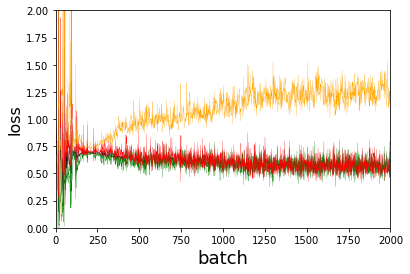

In [13]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()


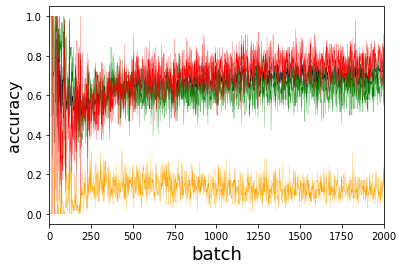

In [14]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()